<a href="https://colab.research.google.com/github/RicardColomOrero/easymoney/blob/main/Easymoney_grupo5_target_long_term_deposit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ENUNCIADO CAPSTONE


## 1.- PowerBI (Opcional)
Hemos decidido reorientar nuestra estrategia comercial hacia el
**aumento de la penetración de la cartera actual de productos en nuestro mercado**, con la idea de obtener una
mejor rentabilidad de nuestra base actual de clientes (lo del cuadrante barato de la matriz de Ansoff).

A cambio, reduciremos la actividad intensiva de captación que veníamos realizando desde que arrancamos. En este sentido, y para acabar de definir la estrategia, estaría genial poder tener algunos análisis que nos ayuden
a tomar decisiones. Como te decía, ahora tenemos un autoservicio, pero esta foto simple no nos ayuda demasiado.
Si ni siquiera sé cuantos productos hemos vendido este mes o si son los clientes nuevos quiénes contratan o los que ya teníamos!

Sería genial incluso que pudieses utilizar el reciente producto adquirido
PowerBI para **preparar unos KPI’s de lo que tenemos en la empresa**

## 2.- Propensión (modelo de propensión a compra)

Una vez que hayamos hecho el **análisis de nuestra BBDD nos gustaría poder vender más y mejor nuestros productos**, sé que los data scientist tienen una “bola de cristal” y saben qué clientes son más propensos a
comprar nuestros productos así que te pido por favor hagas un **modelo de propensión a compra**, se que tenemos muchos productos, así que te **,dejo a tu criterio científico qué productos elegir, o pueden ser varios,**, ya
me sorprenderás

## 3.- Segmentación

Una vez obtenido la propensión de los productos sería genial poder conocer mejor a nuestros clientes para orientar nuestra actividad comercial. Hace tiempo vengo teniendo la idea de que podríamos **segmentar la base
de clientes en 7 u 8 grupos de clientes similares**... sería genial** identificarlos, y poder saber cómo son los clientes
que pertenecen a estos grupos**... nos ayudaría muchísimo a la hora de definir todo nuestro plan de marketing de cara a futuro!

## 4.- Caso de uso

Perfecto! Tenemos las segmentaciones de clientes, tenemos las propensiones y ahora lo que nos falta es realizar
**un caso de uso que nos permita estimar en base a una campaña X cuánto dinero podemos ganar**,

¿A cuántos clientes tenemos que impactar?

¿Qué productos ofrecer?

¿Impactamos a todos lo segmentos indicados?

**Restricción de 10.000 clientes para la campaña.**

# Importación de librerías

In [32]:
import numpy as np # Arrays
import pandas as pd # Series and Dataframes

from google.colab import files

#visualizacion
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.max_rows = 200
plt.style.use('ggplot') # Beautify Plots

#Modelling
from sklearn import model_selection
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb



In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Importación dataset

In [34]:
#file_dir = "/content/drive/MyDrive/NUCLIO/TFM  Data Science/datasets_TFM_y_diccionario/" #Ricard file_dir
file_dir = "/content/drive/MyDrive/TFM  Data Science/datasets_TFM_y_diccionario/" #Eva file_dir
#file_dir = "/content/drive/MyDrive/Master_DS/TFM_Data_Science/datasets_TFM_y_diccionario/" #Culebra file_dir

In [35]:
file_sales ="sales.csv"
file_product_description ="product_description.csv"
file_customer_sociodemographics ="customer_sociodemographics.csv"
file_customer_commercial_activity = "customer_commercial_activity.csv"
file_customer_products ="customer_products.csv"
file_provincias = "inform_adicional_por_provincias.csv"

In [36]:
sales_raw = pd.read_csv(file_dir + file_sales)
product_description_raw = pd.read_csv(file_dir +file_product_description)
customer_sociodemographics_raw = pd.read_csv(file_dir + file_customer_sociodemographics)
customer_commercial_activity_raw = pd.read_csv(file_dir + file_customer_commercial_activity)
customer_products_raw = pd.read_csv(file_dir + file_customer_products)

In [37]:
info_provincias_raw = pd.read_csv(file_dir + file_provincias)

In [38]:
del file_sales
del file_product_description
del file_customer_sociodemographics
del file_customer_commercial_activity
del file_customer_products
del file_provincias

# 2.- DATA UNDERSTANDING

In [39]:
def report_df(df, verbose = True):
    '''
    Hace un report simple sobre el DataFrame suministrado.
    '''
    print("***INFO***")
    print(df.info(verbose = verbose))

    print("***DESCRIPTIVOS CATEGORICAS***")
    try:
      print(df.describe(include = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***DESCRIPTIVOS NUMÉRICAS***")
    try:
      print(df.describe(exclude = ['object']))
    except:
          print("Oops!  No hay variables categóricas")

    print("***NULOS***")
    total_nulos = df.isnull().sum().sum()
    print(df.isnull().sum())
    print(f"Tenemos un total de {total_nulos} nulos")

### Sales

* pk_sale: Identificador de venta - (primary key)
* cid: Identificador de cliente - (foreing key)
* month_sale: Mes de venta. Mes en el que se contrata un producto.
* product_ID: Identificador de producto  - (foreing key)
* net_margin: Margen neto generado por la venta ($)

In [40]:
# Análisis inicial de sales

report_df(sales_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Unnamed: 0  240773 non-null  int64  
 1   pk_sale     240773 non-null  int64  
 2   cid         240773 non-null  int64  
 3   month_sale  240773 non-null  object 
 4   product_ID  240773 non-null  int64  
 5   net_margin  240773 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 11.0+ MB
None
***DESCRIPTIVOS CATEGORICAS***
        month_sale
count       240773
unique          16
top     2018-10-01
freq         27693
***DESCRIPTIVOS NUMÉRICAS***
          Unnamed: 0        pk_sale           cid     product_ID  \
count  240773.000000  240773.000000  2.407730e+05  240773.000000   
mean   120386.000000  127052.000000  1.363934e+06    3945.408202   
std     69505.322519   69505.322519  1.751721e+05    1632.821700   
min         0.000000    6666.000000  1.589100e+0

In [41]:
# ACCIONES A LLEVAR A CABO

# Eliminar columna Unnamed
# Renombrar columnas para alinear el naming, por ejemplo variable cid como "client_ID", pk_sale como "sale_ID"
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
# Cambiar tipo de month_sale a fecha
# Disgregar la fecha en mes, año... (otros: trimestre, fin de semana, festivo...)


### Product Description

* pk_product_ID	= Identificador de producto - (primary key)
* product_desc	= Descripción del producto
* family_product	= Vertical del producto. Grupo al que pertenece.

In [42]:
# Análisis inicial de product description

report_df(product_description_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      13 non-null     int64 
 1   pk_product_ID   13 non-null     int64 
 2   product_desc    13 non-null     object
 3   family_product  13 non-null     object
dtypes: int64(2), object(2)
memory usage: 544.0+ bytes
None
***DESCRIPTIVOS CATEGORICAS***
       product_desc family_product
count            13             13
unique           13              5
top       em_acount        account
freq              1              4
***DESCRIPTIVOS NUMÉRICAS***
       Unnamed: 0  pk_product_ID
count    13.00000      13.000000
mean      6.00000    3614.538462
std       3.89444    2564.251438
min       0.00000    1119.000000
25%       3.00000    2235.000000
50%       6.00000    2336.000000
75%       9.00000    4033.000000
max      12.00000    9001.000000
***NULOS***
Unnamed: 0        0

In [43]:
# ACCIONES A LLEVAR A CABO

# Eliminar columna Unnamed

### Customer Sociodemographics

* pk_cid =	Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* deceased =	Indicador de fallecimiento
* gender =	Sexo del cliente
* region_code =	Provincia de residencia del cliente (para ES)
* salary =	Ingresos brutos de la unidad familiar
* country_id =	País de residencia del cliente
* age =	Edad del cliente

In [44]:
report_df(customer_sociodemographics_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 9 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   pk_cid        int64  
 2   pk_partition  object 
 3   country_id    object 
 4   region_code   float64
 5   gender        object 
 6   age           int64  
 7   deceased      object 
 8   salary        float64
dtypes: float64(2), int64(3), object(4)
memory usage: 409.4+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition country_id   gender deceased
count       5962924    5962924  5962899  5962924
unique           17         41        2        2
top         2019-05         ES        H        N
freq         442995    5960672  3087502  5961849
***DESCRIPTIVOS NUMÉRICAS***
         Unnamed: 0        pk_cid   region_code           age        salary
count  5.962924e+06  5.962924e+06  5.960660e+06  5.962924e+06  4.421820e+06
mean   7.155425e+06  1.234930e+06  2.581440e+01  2.976

In [45]:
customer_sociodemographics_raw["country_id"].value_counts(normalize = True).head()

ES    0.999622
GB    0.000074
FR    0.000038
DE    0.000033
US    0.000033
Name: country_id, dtype: float64

In [46]:
customer_sociodemographics_raw["region_code"].value_counts()

28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      34790
4.0       32680
31.0      31241
49.0      30965
23.0      30955
38.0      29001
34.0      27545
19.0      26762
40.0      21658
5.0       21300
22.0      21112
20.0      18833
1.0       12999
44.0      12616
42.0       8500
51.0       2896
52.0       2638
Name: region_code, dtype: int64

In [47]:
# ACCIONES CUSTOMER SOCIODEMOGRAPHICS

# Gestionar nulos: (Culebra: tenemos modelo de clasificación así que lo que haremos será ponerles valores extremos)
#     region_code
#     gender
#     salary
# gender > Transformar a 1 y 0
# deceased > Transformar a 1 y 0
# country_id > Agrupar ES, OTHERS



### Customer Commercial Activity

* pk_cid = Identificador de cliente
* pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
* entry_channel =	Canal de captación del cliente
* entry_date =	Fecha en la que realizó la primera contratación a través de easyMoney
* segment =	Segmento comercial del cliente
* active_customer =	Indicador de actividad del cliente en la app EasyMoney

In [48]:
report_df(customer_commercial_activity_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Unnamed: 0       int64  
 1   pk_cid           int64  
 2   pk_partition     object 
 3   entry_date       object 
 4   entry_channel    object 
 5   active_customer  float64
 6   segment          object 
dtypes: float64(1), int64(2), object(4)
memory usage: 318.5+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition entry_date entry_channel             segment
count       5962924    5962924       5829891             5828980
unique           17         53            68                   3
top         2019-05    2016-10           KHE  03 - UNIVERSITARIO
freq         442995     382473       3113947             3900166
***DESCRIPTIVOS NUMÉRICAS***
         Unnamed: 0        pk_cid  active_customer
count  5.962924e+06  5.962924e+06     5.962924e+06
mean   7.155425e+06  1.234930e+06     4.033845e-01


In [49]:
customer_commercial_activity_raw["segment"].value_counts()

03 - UNIVERSITARIO    3900166
02 - PARTICULARES     1830875
01 - TOP                97939
Name: segment, dtype: int64

In [50]:
customer_commercial_activity_raw["entry_channel"].value_counts(normalize = True).head(10)

KHE    0.534135
KFC    0.152768
KHQ    0.101251
KAT    0.071371
KHK    0.039486
KHM    0.030291
KHN    0.018600
KFA    0.013554
KHD    0.013019
RED    0.010395
Name: entry_channel, dtype: float64

In [51]:
# ACCIONES CUSTOMER COMMERCIAL ACTIVITY**


# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de active_customer a boolean
# Establecer primary key como index?
# Gestionar nulos:
#     entry_channel
#     segment
# Cambiar tipo de entry_date a fecha
# Disgregar entry_date en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)
# entry_channel > OneHotEncoding o FrecuencyEncoding ( agrupar 11-12 etiquetas + OTHERS)
# segment > OneHotEncoding

### Customer Products

- pk_cid =	Identificador de cliente
- pk_partition =	Identificador de Partición. Mensualmente se ingesta en la tabla una partición con el estado de la base de clientes.
- credit_card =	Tenencia de tarjetas de crédito
- debit_card =	Tenencia de tarjetas de débito
- em_account_p =	Tenencia de Cuenta easyMoney+
- em_account_pp =	Tenencia de Cuenta easyMoney++
- em_acount =	Tenencia de Cuenta easyMoney
- emc_account =	Tenencia de Cuenta easyMoney Crypto
- funds =	Tenencia de Fondos de inversión
- loans =	Tenencia de Préstamos
- long_term_deposit =	Tenencia de Depósitos a largo plazo
- mortgage =	Tenencia de Mortgage
- payroll =	Tenencia de Domiciliaciones
- payroll_account =	Tenencia de Cuenta bonificada por domiciliaciones
- pension_plan =	Tenencia de Plan de pensiones
- securities =	Tenencia de Valores
- short_term_deposit =	Tenencia de Short-term deposits

In [52]:
report_df(customer_products_raw)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5962924 entries, 0 to 5962923
Data columns (total 18 columns):
 #   Column              Dtype  
---  ------              -----  
 0   Unnamed: 0          int64  
 1   pk_cid              int64  
 2   pk_partition        object 
 3   short_term_deposit  int64  
 4   loans               int64  
 5   mortgage            int64  
 6   funds               int64  
 7   securities          int64  
 8   long_term_deposit   int64  
 9   em_account_pp       int64  
 10  credit_card         int64  
 11  payroll             float64
 12  pension_plan        float64
 13  payroll_account     int64  
 14  emc_account         int64  
 15  debit_card          int64  
 16  em_account_p        int64  
 17  em_acount           int64  
dtypes: float64(2), int64(15), object(1)
memory usage: 818.9+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       pk_partition
count       5962924
unique           17
top         2019-05
freq         442995
***DESCRIPTIVOS

In [53]:
# ACCIONES CUSTOMER PRODUCTS

# Eliminar columna Unnamed
# Cambiar los identificadores (pk_cid) a variable categórica
# Cambiar tipo de columnas booleanas a boolean?
# Establecer primary key como index?
# Gestionar nulos:
#     payroll
#     pension_plan
# Eliminar em_account_pp, no hay datos

# Cambiar tipo de payroll y pension_plan a int

### Análisis del target

In [54]:
# Para el modelo de propensión a compra (supervisado > clasificación) trataremos de averiguar la propensión a compra de ciertos productos de cada cliente
# El último target que proponemos será el "emc_account". Las razones son las siguientes:

# Hay cantidad de datos suficientes de clientes que han adquirido este producto (5.48%), por lo que podemos generar un modelo fiable
# Sin embargo, aún resta un % muy alto por obtenerlo, de manera que tenemos margen de compra por parte de gran parte de los clientes
# Es un activo de inversión que puede resultar interesante de cara a combinar con plan de pensiones. Una cartera pasiva + activa para clientes jóvenes

TARGET = 'long_term_deposit'

In [55]:
for i in ['short_term_deposit', 'loans', 'mortgage', 'funds', 'securities','long_term_deposit', 'em_account_pp','credit_card', 'payroll', 'pension_plan', 'payroll_account','emc_account', 'debit_card', 'em_account_p', 'em_acount']:
    suma_productos = customer_products_raw[i].sum()
    print (f"Suma de {i} = {suma_productos} . La media es de {round((suma_productos/customer_products_raw.shape[0])*100,2)}%")


Suma de short_term_deposit = 15394 . La media es de 0.26%
Suma de loans = 468 . La media es de 0.01%
Suma de mortgage = 324 . La media es de 0.01%
Suma de funds = 20099 . La media es de 0.34%
Suma de securities = 22133 . La media es de 0.37%
Suma de long_term_deposit = 100660 . La media es de 1.69%
Suma de em_account_pp = 0 . La media es de 0.0%
Suma de credit_card = 70866 . La media es de 1.19%
Suma de payroll = 205787.0 . La media es de 3.45%
Suma de pension_plan = 217802.0 . La media es de 3.65%
Suma de payroll_account = 329420 . La media es de 5.52%
Suma de emc_account = 326961 . La media es de 5.48%
Suma de debit_card = 562968 . La media es de 9.44%
Suma de em_account_p = 34 . La media es de 0.0%
Suma de em_acount = 4381602 . La media es de 73.48%


### Distribución de las variables

#### Variables numéricas

In [56]:
for i in sales_raw.select_dtypes(include= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

Unnamed: 0 0         1
160520    1
160508    1
160509    1
160510    1
         ..
80262     1
80263     1
80264     1
80265     1
240772    1
Name: Unnamed: 0, Length: 240773, dtype: int64
pk_sale 6666      1
167186    1
167174    1
167175    1
167176    1
         ..
86928     1
86929     1
86930     1
86931     1
247438    1
Name: pk_sale, Length: 240773, dtype: int64
cid 1387215    10
1436512     9
1380507     9
1402957     9
1402199     9
           ..
1409414     1
1409413     1
1409412     1
1409410     1
1553571     1
Name: cid, Length: 152754, dtype: int64
product_ID 4657    117435
3819     38840
1364     19369
2234     18750
2235     18110
8871     12323
2312      5206
2335      4441
2336      4227
2673      1157
1119       880
9001        25
4033        10
Name: product_ID, dtype: int64
net_margin 63.1       890
64.8       854
63.9       851
64.1       848
62.7       841
          ... 
4917.3       1
5698.9       1
5708.1       1
11009.5      1
34.5         1
Name: net_margi

In [57]:
for i in customer_products_raw.select_dtypes(include= ["number"]).columns:
  print(i, customer_products_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
short_term_deposit 0    5947530
1      15394
Name: short_term_deposit, dtype: int64
loans 0    5962456
1        468
Name: loans, dtype: int64
mortgage 0    5962600
1        324
Name: mortgage, dtype: int64
funds 0    5942825
1      20099
Name: funds, dtype: int64
securities 0    5940791
1      22133
Name: securities, dtype: int64
long_term_deposit 0    5862264
1     100660
Name: long_term_deposit, dtype: int64
em_account_pp 0    5962924
Name: em_account_pp, dtype: int64
credit_card 0    5892058
1      70866
Name: credit_card, dtype: int64
payroll 0.0    5757076
1.0     205787


In [58]:
for i in customer_sociodemographics_raw.select_dtypes(include= ["number"]).columns:
     print(i, customer_sociodemographics_raw[i].value_counts())

Unnamed: 0 0           1
9344701     1
9344699     1
9344698     1
9344697     1
           ..
5074084     1
5074083     1
5074082     1
5074081     1
13647308    1
Name: Unnamed: 0, Length: 5962924, dtype: int64
pk_cid 1375586    17
1328781    17
1328783    17
1328784    17
1328786    17
           ..
1521045     1
1545224     1
1470941     1
1521049     1
1550586     1
Name: pk_cid, Length: 456373, dtype: int64
region_code 28.0    1185757
8.0      600362
46.0     358142
30.0     296856
41.0     290447
15.0     254891
29.0     187911
36.0     175850
3.0      171358
11.0     160894
33.0     134562
50.0     132983
6.0      122587
35.0     121982
47.0     116948
18.0     102789
45.0     102328
37.0      92538
10.0      83283
14.0      75405
2.0       72071
21.0      72037
13.0      70092
39.0      69589
12.0      68709
7.0       62436
32.0      54639
27.0      52783
43.0      51782
17.0      50749
9.0       47746
25.0      46887
16.0      36094
24.0      35426
48.0      35256
26.0      3

#### Variables categóricas

In [59]:
for i in sales_raw.select_dtypes(exclude= ["number"]).columns:
     print(i, sales_raw[i].value_counts())

month_sale 2018-10-01    27693
2018-09-01    24488
2018-08-01    21054
2018-07-01    20602
2018-11-01    19155
2018-02-01    15182
2018-12-01    15015
2019-01-01    11872
2018-03-01    11668
2018-06-01    11558
2019-03-01    11506
2019-02-01    11360
2019-05-01    10211
2018-04-01     9962
2019-04-01     9889
2018-05-01     9558
Name: month_sale, dtype: int64


In [60]:
for i in customer_commercial_activity_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_commercial_activity_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
entry_date 2016-10    382473
2017-10    340613
2015-10    310295
2017-09    294752
2017-07    267173
2016-08    252704
2015-08    221984
2015-07    220941
2017-11    217751
2015-09    217174
2018-10    216947
2015-11    210687
2016-09    206107
2018-09    202262
2016-07    189225
2016-11    188601
2018-07    178215
2017-08    162534
2018-08    138420
2017-12    123456
2018-11    103073
2016-12     89423
2015-12     82347
2017-01     65539
2018-02     61283
2018-01     59721
2017-06     54925
2018-03     51022
2016-01     50830
2017-02     50561
2017-03     50268
2017-05     50165
2017-04     47729
2018-04     43480
2018-12     41244
2018-05

In [61]:
for i in customer_sociodemographics_raw.select_dtypes(exclude= ["number"]).columns:
  print(i, customer_sociodemographics_raw[i].value_counts())

pk_partition 2019-05    442995
2019-04    439627
2019-03    436183
2019-02    431727
2019-01    426875
2018-12    422481
2018-11    416387
2018-10    402300
2018-09    375323
2018-08    352922
2018-07    339339
2018-06    252104
2018-05    249926
2018-04    247463
2018-03    245258
2018-02    242521
2018-01    239493
Name: pk_partition, dtype: int64
country_id ES    5960672
GB        441
FR        225
DE        199
US        195
CH        194
BR         87
BE         81
VE         79
IE         68
MX         58
AT         51
AR         51
PL         49
IT         45
MA         34
CL         30
CN         28
CA         22
LU         17
ET         17
QA         17
CI         17
SA         17
CM         17
SN         17
MR         17
NO         17
RU         17
CO         17
GA         17
GT         17
DO         17
SE         16
DJ         11
PT         11
JM         11
RO          9
HU          8
DZ          7
PE          4
Name: country_id, dtype: int64
gender H    3087502
V    2875397

# 3.- PRE PROCESSING

In [62]:
def preprocesado_basico(df, cid="pk_cid"):
  # Eliminar columna Unnamed
  df.drop("Unnamed: 0", axis = 1, inplace = True)

  # Renombrar columnas para alinear el naming
  df.rename({cid: "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

  # Cambiar a fecha la partition ID
  df['partition_ID'] = pd.to_datetime(df['partition_ID'])

In [63]:
def setOthers(dataframe, column, num_values=5):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('OTHERS')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('OTHERS')

In [64]:
def comprobar_shapes(df1,df2,df_final):
  print("DF1 = " + str(df1.shape))
  print("DF2 = " + str(df2.shape))
  print("DF_final = " + str(df_final.shape))

## Sales

In [65]:
df_sales1 = sales_raw.copy()

In [66]:
df_sales1.head()

,Unnamed: 0,pk_sale,cid,month_sale,product_ID,net_margin
0,0,6666,33620,2018-05-01,2335,952.9
1,1,6667,35063,2018-06-01,2335,1625.2
2,2,6668,37299,2018-02-01,2335,1279.7
3,3,6669,39997,2018-02-01,2335,1511.9
4,4,6670,44012,2018-02-01,2335,1680.3


In [67]:
# Eliminar columna Unnamed
df_sales1.drop("Unnamed: 0", axis = 1, inplace = True)

In [68]:
# Renombrar columnas para alinear el naming
df_sales1.rename({"cid": "customer_ID",'pk_partition':'partition_ID' },axis='columns',inplace = True)

In [69]:
#elimnar todas excepto,  month_sale, customer_id, y product_ID
df_sales1.drop("pk_sale", axis = 1, inplace = True) # Se elimina por no aportar nada, es un ID único y el que usaremos será el customer_id
df_sales1.drop("net_margin", axis = 1, inplace = True) # Se elimina por ser autoexplicativa y provocar data leakage

In [70]:
# Cambiar los identificadores (product_ID, customer_ID) a variable categórica
df_sales1["product_ID"] = df_sales1["product_ID"].astype("object")
df_sales1["customer_ID"] = df_sales1["customer_ID"].astype("object")

In [71]:
# Cambiar tipo de month_sale a fecha

df_sales1["month_sale"] = pd.to_datetime(df_sales1["month_sale"], format = "%Y/%m/%d")

# Cambiar tipo de customer_ID a número

df_sales1['customer_ID']=df_sales1['customer_ID'].astype('int')

In [72]:
df_sales1['merge_date']=df_sales1['month_sale']-pd.DateOffset(months=1)

In [73]:
# Disgregar la fecha en mes, año, día, día de la semana (otros: trimestre, fin de semana, festivo...)

#df_sales1["month_sales"] = df_sales1["month_sale"].dt.month
#df_sales1["year_sales"] = df_sales1["month_sale"].dt.year

In [74]:
df_sales1.head()

,customer_ID,month_sale,product_ID,merge_date
0,33620,2018-05-01,2335,2018-04-01
1,35063,2018-06-01,2335,2018-05-01
2,37299,2018-02-01,2335,2018-01-01
3,39997,2018-02-01,2335,2018-01-01
4,44012,2018-02-01,2335,2018-01-01


In [75]:
report_df(df_sales1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240773 entries, 0 to 240772
Data columns (total 4 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_ID  240773 non-null  int64         
 1   month_sale   240773 non-null  datetime64[ns]
 2   product_ID   240773 non-null  object        
 3   merge_date   240773 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 7.3+ MB
None
***DESCRIPTIVOS CATEGORICAS***
        product_ID
count       240773
unique          13
top           4657
freq        117435
***DESCRIPTIVOS NUMÉRICAS***
         customer_ID           month_sale           merge_date
count   2.407730e+05               240773               240773
unique           NaN                   16                   16
top              NaN  2018-10-01 00:00:00  2018-09-01 00:00:00
freq             NaN                27693                27693
first            NaN  2018-02-01 00

<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))
<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


## Product Description

In [76]:
product_description_1 = product_description_raw.copy()

In [77]:
product_description_1.head()

,Unnamed: 0,pk_product_ID,product_desc,family_product
0,0,4657,em_acount,account
1,1,3819,debit_card,payment_card
2,2,1364,pension_plan,pension_plan
3,3,2234,payroll,account
4,4,2235,payroll_account,account


In [78]:
# Eliminar columna Unnamed
product_description_1.drop("Unnamed: 0", axis = 1, inplace = True)

In [79]:
report_df(product_description_1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   pk_product_ID   13 non-null     int64 
 1   product_desc    13 non-null     object
 2   family_product  13 non-null     object
dtypes: int64(1), object(2)
memory usage: 440.0+ bytes
None
***DESCRIPTIVOS CATEGORICAS***
       product_desc family_product
count            13             13
unique           13              5
top       em_acount        account
freq              1              4
***DESCRIPTIVOS NUMÉRICAS***
       pk_product_ID
count      13.000000
mean     3614.538462
std      2564.251438
min      1119.000000
25%      2235.000000
50%      2336.000000
75%      4033.000000
max      9001.000000
***NULOS***
pk_product_ID     0
product_desc      0
family_product    0
dtype: int64
Tenemos un total de 0 nulos


## Customer Sociodemographics

In [80]:
#hacemos una copia del dataset par eliminar los deceased yes
df_customer_soc1 = customer_sociodemographics_raw[customer_sociodemographics_raw['deceased']=='N'].copy()

In [81]:
preprocesado_basico(df_customer_soc1)

In [82]:
df_customer_soc1.drop("deceased", axis = 1, inplace = True)

In [83]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,ES,29.0,H,35,87218.10
1,1050611,2018-01-01,ES,13.0,V,23,35548.74
2,1050612,2018-01-01,ES,13.0,V,23,122179.11
3,1050613,2018-01-01,ES,50.0,H,22,119775.54
4,1050614,2018-01-01,ES,50.0,V,23,NaN


In [84]:
report_df(df_customer_soc1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5961849 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   customer_ID   int64         
 1   partition_ID  datetime64[ns]
 2   country_id    object        
 3   region_code   float64       
 4   gender        object        
 5   age           int64         
 6   salary        float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 363.9+ MB
None
***DESCRIPTIVOS CATEGORICAS***
       country_id   gender
count     5961849  5961824
unique         41        2
top            ES        H
freq      5959602  3087137
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID   region_code           age  \
count   5.961849e+06              5961849  5.959590e+06  5.961849e+06   
unique           NaN                   17           NaN           NaN   
top              NaN  2019-05-01 00:00:00           NaN           NaN   
freq             NaN               442909           NaN           NaN   
first            NaN  2018-01-01 00:00:00           NaN           NaN   
last             NaN  2019-05-01 00:00:00           NaN           NaN   
mean    1.234946e+06                  NaN  2.581401e+01  2.975331e+01   
std     1.622883e+05                  NaN  1.359580e+01  1.196603e+01   
min     1.589100e+04                  NaN  1.000000e+00  2.000000e+00   
25%     1.112541e+06                  NaN  1.300000e+01  2.200000e+01   
50%     1.231108e+06                  NaN  2.800000e+01  2.500000e+01   
75%     1.352348e+06                  NaN  3.600000e+01  3.400000e+01   
max     1.553689e+06                  NaN  5.200000

Gestión de nulos

In [85]:
# Asignamos valor extremos a "salary", "gender", "region_code" ya que vamos a hacer un DecisionTree

print(df_customer_soc1["salary"].describe())
df_customer_soc1["salary"].fillna(value = 0, inplace = True)

print(df_customer_soc1["gender"].value_counts(normalize = True))
df_customer_soc1["gender"].fillna(value = 2, inplace = True)

print(df_customer_soc1["region_code"].describe())
df_customer_soc1["region_code"].fillna(value = 1000, inplace = True)

count    4.420973e+06
mean     1.155814e+05
std      2.000178e+05
min      1.202730e+03
25%      6.141360e+04
50%      8.843820e+04
75%      1.313081e+05
max      2.889440e+07
Name: salary, dtype: float64
H    0.517818
V    0.482182
Name: gender, dtype: float64
count    5.959590e+06
mean     2.581401e+01
std      1.359580e+01
min      1.000000e+00
25%      1.300000e+01
50%      2.800000e+01
75%      3.600000e+01
max      5.200000e+01
Name: region_code, dtype: float64


Agrupación

In [86]:
#agrupamos country_id en ES y OTHERS
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

df_customer_soc1['country_id'] = setOthers(df_customer_soc1,'country_id',num_values=1)

print()
print((df_customer_soc1["country_id"].value_counts(normalize=True)*100).head())

#df1.drop("country_id", axis = 1, inplace = True)

ES    99.962310
GB     0.007397
FR     0.003774
DE     0.003338
US     0.003271
Name: country_id, dtype: float64

ES        99.96231
OTHERS     0.03769
Name: country_id, dtype: float64


In [87]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,region_code,gender,age,salary
0,1375586,2018-01-01,ES,29.0,H,35,87218.10
1,1050611,2018-01-01,ES,13.0,V,23,35548.74
2,1050612,2018-01-01,ES,13.0,V,23,122179.11
3,1050613,2018-01-01,ES,50.0,H,22,119775.54
4,1050614,2018-01-01,ES,50.0,V,23,0.00


In [88]:
report_df(df_customer_soc1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5961849 entries, 0 to 5962923
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   customer_ID   int64         
 1   partition_ID  datetime64[ns]
 2   country_id    category      
 3   region_code   float64       
 4   gender        object        
 5   age           int64         
 6   salary        float64       
dtypes: category(1), datetime64[ns](1), float64(2), int64(2), object(1)
memory usage: 324.1+ MB
None
***DESCRIPTIVOS CATEGORICAS***
         gender
count   5961849
unique        3
top           H
freq    3087137
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID country_id   region_code  \
count   5.961849e+06              5961849    5961849  5.961849e+06   
unique           NaN                   17          2           NaN   
top              NaN  2019-05-01 00:00:00         ES           NaN   
freq             NaN               442909    5959602           NaN   
first            NaN  2018-01-01 00:00:00        NaN           NaN   
last             NaN  2019-05-01 00:00:00        NaN           NaN   
mean    1.234946e+06                  NaN        NaN  2.618314e+01   
std     1.622883e+05                  NaN        NaN  2.332893e+01   
min     1.589100e+04                  NaN        NaN  1.000000e+00   
25%     1.112541e+06                  NaN        NaN  1.300000e+01   
50%     1.231108e+06                  NaN        NaN  2.800000e+01   
75%     1.352348e+06                  NaN        NaN  3.600000e+01   
max     1.553689e+06                  NaN        NaN  1.000000e+03   

                 ag

In [89]:
# Añadimos información de las provincias
df_customer_soc1 = df_customer_soc1.merge(info_provincias_raw, how = "left", left_on = "region_code", right_on = "codigo")

In [90]:
df_customer_soc1.isnull().sum()

customer_ID             0
partition_ID            0
country_id              0
region_code             0
gender                  0
age                     0
salary                  0
provincia            2259
codigo               2259
renta_neta_media     2259
renta_bruta_media    2259
tasa_de_paro         2259
tasa_de_empleo       2259
dtype: int64

In [91]:
del df_customer_soc1["region_code"]
del df_customer_soc1["codigo"]

In [92]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,ES,H,35,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050611,2018-01-01,ES,V,23,35548.74,Ciudad Real,10570.0,11811.0,18.35,44.95
2,1050612,2018-01-01,ES,V,23,122179.11,Ciudad Real,10570.0,11811.0,18.35,44.95
3,1050613,2018-01-01,ES,H,22,119775.54,Zaragoza,13637.0,16156.0,12.24,51.20
4,1050614,2018-01-01,ES,V,23,0.00,Zaragoza,13637.0,16156.0,12.24,51.20


In [93]:
df_customer_soc1["provincia"].fillna(value = "No definido", inplace = True)
df_customer_soc1["renta_neta_media"].fillna(np.mean(df_customer_soc1["renta_neta_media"]), inplace = True)
df_customer_soc1["renta_bruta_media"].fillna(np.mean(df_customer_soc1["renta_bruta_media"]), inplace = True)
df_customer_soc1["tasa_de_paro"].fillna(np.mean(df_customer_soc1["tasa_de_paro"]), inplace = True)
df_customer_soc1["tasa_de_empleo"].fillna(np.mean(df_customer_soc1["tasa_de_empleo"]), inplace = True)

## Customer commercial activity

In [94]:
# La cantidad de clientes inactivos son 317.179
customer_commercial_activity_raw[customer_commercial_activity_raw["active_customer"] == 0]["pk_cid"].nunique()

317179

In [95]:
# Eliminamos los clientes inactivos del dataset al no ser target
df_cust_com_act1 = customer_commercial_activity_raw[customer_commercial_activity_raw['active_customer']==1].copy()

In [96]:
preprocesado_basico(df_cust_com_act1)

In [97]:
# Creamos la variable "Antiguedad" restando la última fecha de partition por el entry_date
df_cust_com_act1['antiguedad']=pd.to_datetime(df_cust_com_act1['partition_ID'].max())-pd.to_datetime(df_cust_com_act1['entry_date'])

In [98]:
df_cust_com_act1['antiguedad']= round(df_cust_com_act1['antiguedad'].astype(int)/86400000000000/30) # En meses

In [99]:
df_cust_com_act1.head()

,customer_ID,partition_ID,entry_date,entry_channel,active_customer,segment,antiguedad
0,1375586,2018-01-01,2018-01,KHL,1.0,02 - PARTICULARES,16.0
4,1050614,2018-01-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,46.0
7,1050617,2018-01-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,46.0
12,1050623,2018-01-01,2015-08,KHE,1.0,03 - UNIVERSITARIO,46.0
13,1050624,2018-01-01,2015-08,KHE,1.0,02 - PARTICULARES,46.0


In [100]:
df_cust_com_act1['antiguedad'].unique()

array([16., 46., 22., 19., 42., 45., 41., 20., 21., 44., 34., 38., 17.,
       40., 29., 43., 36., 26., 30., 31., 28., 18., 23., 25., 27., 35.,
       39., 47., 32., 24., 49., 48., 50., 33., 51., 52., 53., 15., 14.,
       13., 12., 11., 10.,  9.,  8.,  7.,  6.,  5.,  4.,  3.,  2.,  1.,
        0.])

In [101]:
df_cust_com_act1.drop("active_customer", axis = 1, inplace = True)
df_cust_com_act1.drop("entry_date", axis = 1, inplace = True)

Gestión de nulos

In [102]:
# Función para imputar nulos de Segment y Entry Channel

def imputacion_nulos(df,col):
  # Array con los ids que tienen nulos
  ids_null_unique = df[(df[col].isnull()==True)]['customer_ID'].unique()
  # Dataframe donde revisamos si en la última carga de datos hay un valor para los ids que tienen "entry_channel" nulo.
  valores_nulos = df[(df.customer_ID.isin(ids_null_unique))&(df[col].notnull())&(df['partition_ID']== "2019-05")][['customer_ID',col]]
  # Si el id con "entry_channel" nulo tenía un valor correcto en la última partition, se lo asignaremos a los valores nulos.
  dict_nulos = dict(zip(valores_nulos['customer_ID'],valores_nulos[col]))
  df.set_index('customer_ID',inplace = True)
  # Imputamos los últimos valores registrados correctamente en "segment" y "entry_channel"
  df[col].fillna(dict_nulos,inplace=True)
  df.reset_index(inplace = True)

In [103]:
imputacion_nulos(df_cust_com_act1,col = 'segment')

In [104]:
imputacion_nulos(df_cust_com_act1,col = 'entry_channel')

In [105]:
# Imputación de valores extremos a los nulos que no se han podido deducir por el histórico
df_cust_com_act1['segment'].fillna(value='04 - NO SEGMENT',inplace=True)
df_cust_com_act1['entry_channel'].fillna(value='ZZZ',inplace=True)

Agrupación

In [106]:
df_cust_com_act1['entry_channel']=setOthers(df_cust_com_act1,'entry_channel',num_values=13)

In [107]:
df_cust_com_act1.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0


In [108]:
report_df(df_cust_com_act1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2405351 entries, 0 to 2405350
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   customer_ID    int64         
 1   partition_ID   datetime64[ns]
 2   entry_channel  category      
 3   segment        object        
 4   antiguedad     float64       
dtypes: category(1), datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 75.7+ MB
None
***DESCRIPTIVOS CATEGORICAS***
                  segment
count             2405351
unique                  4
top     02 - PARTICULARES
freq              1155032
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID entry_channel    antiguedad
count   2.405351e+06              2405351       2405351  2.405351e+06
unique           NaN                   17            14           NaN
top              NaN  2019-05-01 00:00:00           KHE           NaN
freq             NaN               171568        788558           NaN
first            NaN  2018-01-01 00:00:00           NaN           NaN
last             NaN  2019-05-01 00:00:00           NaN           NaN
mean    1.235924e+06                  NaN           NaN  2.651835e+01
std     1.769750e+05                  NaN           NaN  1.342293e+01
min     1.589100e+04                  NaN           NaN  0.000000e+00
25%     1.124738e+06                  NaN           NaN  1.700000e+01
50%     1.251650e+06                  NaN           NaN  2.500000e+01
75%     1.368966e+06                  NaN           NaN  3.600000e+01
max     1.553571e+06                  NaN           NaN  5.300000e+01
***NULOS***
customer

## Customer products

In [109]:
df_cust_prod1 = customer_products_raw.copy()

In [110]:
preprocesado_basico(df_cust_prod1)

In [111]:
df_cust_prod1.head()

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,long_term_deposit,em_account_pp,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_account_p,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,1


In [112]:
# Eliminamos el Target de la tabla, lo crearemos a posteriori

df_cust_prod1.drop("long_term_deposit", axis = 1, inplace = True)

In [113]:
# Eliminamos variables de baja varianza

print(df_cust_prod1["em_account_p"].value_counts(normalize = True)*100)
print(df_cust_prod1["em_account_pp"].value_counts(normalize = True)*100)

del df_cust_prod1['em_account_pp']
del df_cust_prod1['em_account_p']

0    99.99943
1     0.00057
Name: em_account_p, dtype: float64
0    100.0
Name: em_account_pp, dtype: float64


In [114]:
# Eliminamos valores nulos de "payroll"

df_cust_prod1.dropna(subset = ['payroll'], inplace = True)

In [115]:
# Cambiamos el type de las variables con float a int

df_cust_prod1['payroll'] = df_cust_prod1[['payroll']].applymap(int)
df_cust_prod1['pension_plan'] = df_cust_prod1[['pension_plan']].applymap(int)

In [116]:
df_cust_prod1.head()

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1


In [117]:
report_df(df_cust_prod1)

***INFO***
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5962863 entries, 0 to 5962923
Data columns (total 14 columns):
 #   Column              Dtype         
---  ------              -----         
 0   customer_ID         int64         
 1   partition_ID        datetime64[ns]
 2   short_term_deposit  int64         
 3   loans               int64         
 4   mortgage            int64         
 5   funds               int64         
 6   securities          int64         
 7   credit_card         int64         
 8   payroll             int64         
 9   pension_plan        int64         
 10  payroll_account     int64         
 11  emc_account         int64         
 12  debit_card          int64         
 13  em_acount           int64         
dtypes: datetime64[ns](1), int64(13)
memory usage: 682.4 MB
None
***DESCRIPTIVOS CATEGORICAS***
Oops!  No hay variables categóricas
***DESCRIPTIVOS NUMÉRICAS***


<ipython-input-39-0319c75cb06a>:16: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(exclude = ['object']))


         customer_ID         partition_ID  short_term_deposit         loans  \
count   5.962863e+06              5962863        5.962863e+06  5.962863e+06   
unique           NaN                   17                 NaN           NaN   
top              NaN  2019-05-01 00:00:00                 NaN           NaN   
freq             NaN               442995                 NaN           NaN   
first            NaN  2018-01-01 00:00:00                 NaN           NaN   
last             NaN  2019-05-01 00:00:00                 NaN           NaN   
mean    1.234930e+06                  NaN        2.581646e-03  7.848579e-05   
std     1.623026e+05                  NaN        5.074427e-02  8.858874e-03   
min     1.589100e+04                  NaN        0.000000e+00  0.000000e+00   
25%     1.112532e+06                  NaN        0.000000e+00  0.000000e+00   
50%     1.231096e+06                  NaN        0.000000e+00  0.000000e+00   
75%     1.352339e+06                  NaN        0.0

## Merge de tablas

###customer commercial activity & cust_sociodemographics

In [118]:
df_customer_soc1.shape

(5961849, 11)

In [119]:
df_customer_soc1.isnull().sum()

customer_ID          0
partition_ID         0
country_id           0
gender               0
age                  0
salary               0
provincia            0
renta_neta_media     0
renta_bruta_media    0
tasa_de_paro         0
tasa_de_empleo       0
dtype: int64

In [120]:
df_customer_soc1[df_customer_soc1['customer_ID']==1128010]

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
51301,1128010,2018-01-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
431344,1128010,2018-02-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
684739,1128010,2018-03-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
915770,1128010,2018-04-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
1028803,1128010,2018-05-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
1280356,1128010,2018-06-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
1496192,1128010,2018-07-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
2025908,1128010,2018-08-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
2364608,1128010,2018-09-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6
2619858,1128010,2018-10-01,ES,V,80,79498.98,Madrid,15579.0,15183.0,13.25,53.6


In [121]:
customer_sociodemographics_raw[customer_sociodemographics_raw['pk_cid']==1128010]
#cheqeuo un cliente que tiene nulos al mergear, es un cliente que fallece en enero del 2019, por eso no tiene datos a partir de esa fecha porque hemos eliminado los clientes a partir de su fallecimiento.

,Unnamed: 0,pk_cid,pk_partition,country_id,region_code,gender,age,deceased,salary
51314,51672,1128010,2018-01,ES,28.0,V,80,N,79498.98
431429,1201987,1128010,2018-02,ES,28.0,V,80,N,79498.98
684874,1839472,1128010,2018-03,ES,28.0,V,80,N,79498.98
915942,2453395,1128010,2018-04,ES,28.0,V,80,N,79498.98
1029003,2566842,1128010,2018-05,ES,28.0,V,80,N,79498.98
1280601,3200394,1128010,2018-06,ES,28.0,V,80,N,79498.98
1496483,4246139,1128010,2018-07,ES,28.0,V,80,N,79498.98
2026273,5112720,1128010,2018-08,ES,28.0,V,80,N,79498.98
2365038,6135625,1128010,2018-09,ES,28.0,V,80,N,79498.98
2620331,6390942,1128010,2018-10,ES,28.0,V,80,N,79498.98


In [122]:
df_customer_soc1.head()

,customer_ID,partition_ID,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,ES,H,35,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050611,2018-01-01,ES,V,23,35548.74,Ciudad Real,10570.0,11811.0,18.35,44.95
2,1050612,2018-01-01,ES,V,23,122179.11,Ciudad Real,10570.0,11811.0,18.35,44.95
3,1050613,2018-01-01,ES,H,22,119775.54,Zaragoza,13637.0,16156.0,12.24,51.20
4,1050614,2018-01-01,ES,V,23,0.00,Zaragoza,13637.0,16156.0,12.24,51.20


In [123]:
df_cust_com_act1.shape

(2405351, 5)

In [124]:
df_cust_com_act1.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0


In [125]:
#customer commercial activity tiene menos filas porque hemos eliminado los clientes inactivos

In [126]:
df_merge1=df_cust_com_act1.merge(df_customer_soc1,how="left", on=["customer_ID","partition_ID"])

In [127]:
df_merge1.shape

(2405351, 14)

In [128]:
df_merge1.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,13637.0,16156.0,12.24,51.20
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,13637.0,16156.0,12.24,51.20
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,11737.0,14848.0,13.57,44.16
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,13637.0,16156.0,12.24,51.20


In [129]:
df_merge1.isnull().sum()

customer_ID            0
partition_ID           0
entry_channel          0
segment                0
antiguedad             0
country_id           718
gender               718
age                  718
salary               718
provincia            718
renta_neta_media     718
renta_bruta_media    718
tasa_de_paro         718
tasa_de_empleo       718
dtype: int64

In [130]:
#718 nulos de la tabla de sociodemographics, son clientes que no existen en la tabla de sociodemographics, son las filas de las particiones donde los clientes están fallecidos, los eliminamos

In [131]:
df_merge1[df_merge1['country_id'].isnull()]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
7189,1061593,2018-01-01,KFC,02 - PARTICULARES,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8629,1026360,2018-01-01,KFC,02 - PARTICULARES,47.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10318,1015200,2018-01-01,KFC,02 - PARTICULARES,49.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16752,1106173,2018-01-01,KHE,02 - PARTICULARES,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17608,1108494,2018-01-01,KFC,02 - PARTICULARES,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2391288,1134587,2019-05-01,KFC,02 - PARTICULARES,36.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2393311,1125539,2019-05-01,KFC,02 - PARTICULARES,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2394494,1128010,2019-05-01,KAT,01 - TOP,38.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2396728,1175266,2019-05-01,KFC,02 - PARTICULARES,32.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [132]:
df_merge1[df_merge1['customer_ID']==1128010]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
21454,1128010,2018-01-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
199239,1128010,2018-02-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
316224,1128010,2018-03-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
423192,1128010,2018-04-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
471410,1128010,2018-05-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
592315,1128010,2018-06-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
698111,1128010,2018-07-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
908363,1128010,2018-08-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
1030594,1128010,2018-09-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6
1124588,1128010,2018-10-01,KAT,01 - TOP,38.0,ES,V,80.0,79498.98,Madrid,15579.0,15183.0,13.25,53.6


In [133]:
df_merge1.dropna( inplace = True)

In [134]:
df_merge1.isnull().sum()

customer_ID          0
partition_ID         0
entry_channel        0
segment              0
antiguedad           0
country_id           0
gender               0
age                  0
salary               0
provincia            0
renta_neta_media     0
renta_bruta_media    0
tasa_de_paro         0
tasa_de_empleo       0
dtype: int64

### '+ customer products

In [135]:
df_merge1.shape


(2404633, 14)

In [136]:
df_cust_prod1.shape

(5962863, 14)

In [137]:
df_merge1.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,10261.0,15512.0,22.60,44.20
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,13637.0,16156.0,12.24,51.20
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,13637.0,16156.0,12.24,51.20
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,11737.0,14848.0,13.57,44.16
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,13637.0,16156.0,12.24,51.20


In [138]:
df_cust_prod1.head()

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
0,1375586,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
1,1050611,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
2,1050612,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
3,1050613,2018-01-01,1,0,0,0,0,0,0,0,0,0,0,0
4,1050614,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1


In [139]:
df_merge2=df_merge1.merge(df_cust_prod1,how="left", on=["customer_ID","partition_ID"])


In [140]:
df_merge2.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [141]:
df_merge2.isnull().sum()

customer_ID            0
partition_ID           0
entry_channel          0
segment                0
antiguedad             0
country_id             0
gender                 0
age                    0
salary                 0
provincia              0
renta_neta_media       0
renta_bruta_media      0
tasa_de_paro           0
tasa_de_empleo         0
short_term_deposit    37
loans                 37
mortgage              37
funds                 37
securities            37
credit_card           37
payroll               37
pension_plan          37
payroll_account       37
emc_account           37
debit_card            37
em_acount             37
dtype: int64

In [142]:
#hemos añadido 37 nulos con este merge

In [143]:
df_merge2[df_merge2['loans'].isnull()]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
21666,1132935,2018-01-01,KHN,02 - PARTICULARES,36.0,ES,V,38.0,67679.01,Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45547,1266281,2018-01-01,KHK,02 - PARTICULARES,23.0,ES,H,62.0,0.00,Sevilla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63160,1374202,2018-01-01,KHK,02 - PARTICULARES,16.0,ES,V,51.0,27250.20,Murcia,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65716,1363870,2018-01-01,KHK,03 - UNIVERSITARIO,17.0,ES,H,30.0,82092.24,Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79140,1177738,2018-01-01,KHM,02 - PARTICULARES,32.0,ES,H,44.0,27153.72,"Coruña, A",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83993,1135705,2018-01-01,KFC,02 - PARTICULARES,36.0,ES,V,34.0,78786.42,Castellón/Castelló,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93225,1221067,2018-01-01,KAT,02 - PARTICULARES,30.0,ES,V,41.0,0.00,Melilla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99952,1241619,2018-01-01,KHN,02 - PARTICULARES,27.0,ES,H,45.0,0.00,Granada,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
122702,1253148,2018-02-01,KHN,02 - PARTICULARES,25.0,ES,H,34.0,306586.80,Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
124740,1221067,2018-02-01,KAT,02 - PARTICULARES,30.0,ES,V,41.0,0.00,Melilla,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [144]:
df_merge2[df_merge2['customer_ID']==1237715]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
100268,1237715,2018-01-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
126223,1237715,2018-02-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
235627,1237715,2018-03-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
670695,1237715,2018-06-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
785327,1237715,2018-07-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
853850,1237715,2018-08-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
989653,1237715,2018-09-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1220552,1237715,2018-10-01,KHM,02 - PARTICULARES,28.0,ES,H,36.0,127394.19,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [145]:
df_cust_prod1[df_cust_prod1['customer_ID']==1237715]

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
217101,1237715,2018-01-01,0,0,0,0,0,0,0,0,0,0,0,1
276921,1237715,2018-02-01,0,0,0,0,0,0,0,0,0,0,0,1
1440493,1237715,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,1
1735647,1237715,2018-07-01,0,0,0,0,0,0,0,0,0,0,0,1
1898346,1237715,2018-08-01,0,0,0,0,0,0,0,0,0,0,0,1
2250771,1237715,2018-09-01,0,0,0,0,0,0,0,0,0,0,0,1
2863314,1237715,2018-10-01,0,0,0,0,0,0,0,0,0,0,0,1
3080806,1237715,2018-11-01,0,0,0,0,0,0,0,0,0,0,0,0
3473706,1237715,2018-12-01,0,0,0,0,0,0,0,0,0,0,0,0
4046109,1237715,2019-01-01,0,0,0,0,0,0,0,0,0,0,0,0


In [146]:
df_merge2[df_merge2['customer_ID']==1387288]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
266124,1387288,2018-03-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
520980,1387288,2018-05-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
639159,1387288,2018-06-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
796671,1387288,2018-07-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
896529,1387288,2018-08-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1061944,1387288,2018-09-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1186678,1387288,2018-10-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1343018,1387288,2018-11-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1560357,1387288,2018-12-01,KHK,02 - PARTICULARES,14.0,ES,V,37.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1628717,1387288,2019-01-01,KHK,02 - PARTICULARES,14.0,ES,V,38.0,30365.94,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [147]:
df_cust_prod1[df_cust_prod1['customer_ID']==1387288]

,customer_ID,partition_ID,short_term_deposit,loans,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
1121980,1387288,2018-05-01,0,0,0,0,0,0,0,0,0,0,0,1
1370734,1387288,2018-06-01,0,0,0,0,0,0,0,0,0,0,0,1
1771647,1387288,2018-07-01,0,0,0,0,0,0,0,0,0,0,0,1
1990566,1387288,2018-08-01,0,0,0,0,0,0,0,0,0,0,0,1
2453711,1387288,2018-09-01,0,0,0,0,0,0,0,0,0,0,0,1
2772529,1387288,2018-10-01,0,0,0,0,0,0,0,0,0,0,0,1
3190639,1387288,2018-11-01,0,0,0,0,0,0,0,0,0,0,0,1
3773859,1387288,2018-12-01,0,0,0,0,0,0,0,0,0,0,0,1
3943654,1387288,2019-01-01,0,0,0,0,0,0,0,0,0,0,0,1
4445154,1387288,2019-02-01,0,0,0,0,0,0,0,0,0,0,0,1


In [148]:
#son clientes que en esa partición no tienen datos en la tabla original, eliminamos los nulos

In [149]:
df_merge2.dropna( inplace = True)

In [150]:
df_merge2.isnull().sum()

customer_ID           0
partition_ID          0
entry_channel         0
segment               0
antiguedad            0
country_id            0
gender                0
age                   0
salary                0
provincia             0
renta_neta_media      0
renta_bruta_media     0
tasa_de_paro          0
tasa_de_empleo        0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
dtype: int64

### '+ sales

In [151]:
df_merge2.shape

(2404596, 26)

In [152]:
df_sales1.shape

(240773, 4)

In [153]:
df_merge2.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,mortgage,funds,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [154]:
df_sales1.rename({'merge_date':'partition_ID' },axis='columns',inplace = True)

In [155]:
df_sales1.head()

,customer_ID,month_sale,product_ID,partition_ID
0,33620,2018-05-01,2335,2018-04-01
1,35063,2018-06-01,2335,2018-05-01
2,37299,2018-02-01,2335,2018-01-01
3,39997,2018-02-01,2335,2018-01-01
4,44012,2018-02-01,2335,2018-01-01


In [156]:
df_total4=df_merge2.merge(df_sales1,how="left", on=["customer_ID","partition_ID"])

In [157]:
df_total4.shape

(2433348, 28)

In [ ]:
df_total4.head()

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-02-01,3819
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN


In [ ]:
df_total4.isnull().sum()

customer_ID                 0
partition_ID                0
entry_channel               0
segment                     0
antiguedad                  0
country_id                  0
gender                      0
age                         0
salary                      0
provincia                   0
renta_neta_media            0
renta_bruta_media           0
tasa_de_paro                0
tasa_de_empleo              0
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
credit_card                 0
payroll                     0
pension_plan                0
payroll_account             0
emc_account                 0
debit_card                  0
em_acount                   0
month_sale            2322162
product_ID            2322162
dtype: int64

In [ ]:
df_total4[df_total4['month_sale'].isnull()]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
5,1050625,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433343,1166779,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,57302.85,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433344,1166778,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433345,1166775,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,77784.78,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433346,1166763,2019-05-01,KHE,02 - PARTICULARES,33.0,ES,H,47.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN


In [ ]:
df_total4[df_total4['customer_ID']==1375586]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
159871,1375586,2018-02-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
276756,1375586,2018-03-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
387203,1375586,2018-04-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-05-01,3819
519293,1375586,2018-05-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
638641,1375586,2018-06-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
820489,1375586,2018-07-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
2006783,1375586,2019-03-01,KHL,02 - PARTICULARES,16.0,ES,H,36.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2282156,1375586,2019-05-01,KHL,02 - PARTICULARES,16.0,ES,H,36.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN


In [ ]:
df_total4[df_total4['partition_ID']=='2019-05-01']

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
2261834,657826,2019-05-01,OTHERS,02 - PARTICULARES,49.0,ES,H,44.0,54493.38,Lleida,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261835,657986,2019-05-01,OTHERS,02 - PARTICULARES,40.0,ES,H,39.0,100993.17,Sevilla,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaT,NaN
2261836,657905,2019-05-01,KAT,01 - TOP,27.0,ES,H,85.0,154059.09,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261837,657336,2019-05-01,KAT,02 - PARTICULARES,2.0,ES,V,38.0,0.00,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261838,658184,2019-05-01,KAT,02 - PARTICULARES,49.0,ES,V,42.0,183036.72,Madrid,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2433343,1166779,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,57302.85,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433344,1166778,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433345,1166775,2019-05-01,KHE,03 - UNIVERSITARIO,33.0,ES,V,23.0,77784.78,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2433346,1166763,2019-05-01,KHE,02 - PARTICULARES,33.0,ES,H,47.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN


In [158]:
df_total4[df_total4['partition_ID']=='2019-05-01']['product_ID'].isnull().sum()

171514

In [ ]:
#la ultima partición mayo de 2019 no tiene datos en ventas porque no han sucedido(ventas de Junio del 2019), hay que separar esta parte del dataset.


In [159]:
df_total5=df_total4[df_total4['partition_ID']!='2019-05-01']

In [160]:
df_total_pred=df_total4[df_total4['partition_ID']=='2019-05-01']
##partición para hacer la predicción

In [161]:
df_total5

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
3,1050623,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113538.81,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-02-01,3819
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261829,1297408,2019-04-01,KAT,02 - PARTICULARES,21.0,ES,H,44.0,85419.21,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261830,1297409,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,H,23.0,71878.92,Huelva,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261831,1297410,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,V,47.0,43093.74,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261832,1297412,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,V,34.0,43727.70,Córdoba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN


In [ ]:
df_total5.isnull().sum()

customer_ID                 0
partition_ID                0
entry_channel               0
segment                     0
antiguedad                  0
country_id                  0
gender                      0
age                         0
salary                      0
provincia                   0
renta_neta_media            0
renta_bruta_media           0
tasa_de_paro                0
tasa_de_empleo              0
short_term_deposit          0
loans                       0
mortgage                    0
funds                       0
securities                  0
credit_card                 0
payroll                     0
pension_plan                0
payroll_account             0
emc_account                 0
debit_card                  0
em_acount                   0
month_sale            2150648
product_ID            2150648
dtype: int64

In [ ]:
df_total5[df_total5['month_sale'].isnull()]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.10,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
1,1050614,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2,1050617,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,H,23.0,113316.66,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
4,1050624,2018-01-01,KHE,02 - PARTICULARES,46.0,ES,H,65.0,61605.09,Zaragoza,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
5,1050625,2018-01-01,KHE,03 - UNIVERSITARIO,46.0,ES,V,23.0,0.00,Zamora,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2261829,1297408,2019-04-01,KAT,02 - PARTICULARES,21.0,ES,H,44.0,85419.21,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261830,1297409,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,H,23.0,71878.92,Huelva,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261831,1297410,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,V,47.0,43093.74,Valencia/València,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261832,1297412,2019-04-01,KFC,02 - PARTICULARES,21.0,ES,V,34.0,43727.70,Córdoba,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN


In [ ]:
df_total5[df_total5['customer_ID']==1375586]

,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
0,1375586,2018-01-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
159871,1375586,2018-02-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
276756,1375586,2018-03-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
387203,1375586,2018-04-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2018-05-01,3819
519293,1375586,2018-05-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
638641,1375586,2018-06-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
820489,1375586,2018-07-01,KHL,02 - PARTICULARES,16.0,ES,H,35.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,NaT,NaN
2006783,1375586,2019-03-01,KHL,02 - PARTICULARES,16.0,ES,H,36.0,87218.1,Málaga,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN


In [ ]:
#ahora podemos elimnar los nulos de las columnas de month sale y product_Id porque son ventas que no se han producido
#los valores no-nulos de month_sale y product_id nos indican CUÁNDO se ha producido la adquisición de ese producto,
#si el cliente no ha comprado productos durante el resto de los meses, esos valores son los NULOS

In [162]:
df_total6=df_total5.copy()

In [163]:
df_total6.dropna( inplace = True)

In [164]:
df_total6.isnull().sum()

customer_ID           0
partition_ID          0
entry_channel         0
segment               0
antiguedad            0
country_id            0
gender                0
age                   0
salary                0
provincia             0
renta_neta_media      0
renta_bruta_media     0
tasa_de_paro          0
tasa_de_empleo        0
short_term_deposit    0
loans                 0
mortgage              0
funds                 0
securities            0
credit_card           0
payroll               0
pension_plan          0
payroll_account       0
emc_account           0
debit_card            0
em_acount             0
month_sale            0
product_ID            0
dtype: int64

In [165]:
df_total6.shape

(111186, 28)

In [166]:
# Eliminamos las variables que hemos utilizado para el merge y ya no necesitamos
df_total6.drop("partition_ID", axis = 1, inplace = True)


In [167]:
df_total6.head().T

,3,37,38,39,40
customer_ID,1050623,1050651,1050651,1050652,1050652
entry_channel,KHE,KFC,KFC,KFC,KFC
segment,03 - UNIVERSITARIO,02 - PARTICULARES,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO
antiguedad,46.0,46.0,46.0,46.0,46.0
country_id,ES,ES,ES,ES,ES
gender,H,H,H,H,H
age,23.0,30.0,30.0,31.0,31.0
salary,113538.81,139502.28,139502.28,149099.88,149099.88
provincia,Zamora,"Balears, Illes","Balears, Illes",Valladolid,Valladolid
renta_neta_media,11737.0,12486.0,12486.0,13490.0,13490.0


## Procesamiento de variables del df mergeado

In [168]:
# Reordenación del dataset
df_total6 = df_total6.reindex(columns=[
              'month_sale',
              'product_ID',
              'customer_ID',
              'antiguedad',
              'entry_channel',
              'segment',
              'country_id',
              'gender',
              'age',
              'salary',
              'provincia',
              'renta_neta_media',
              'renta_bruta_media',
              'tasa_de_paro',
              'tasa_de_empleo',
              'short_term_deposit',
              'loans',
              'mortgage',
              'funds',
              'securities',
              'credit_card',
              'payroll',
              'payroll_account',
              'pension_plan',
              'debit_card',
              'em_acount',
              ])

In [169]:
df_pre = df_total6.copy()

In [170]:
# Disgregamos la variable de "month_sale" y eliminamos la variable de fecha
df_pre['sale_month'] = df_pre['month_sale'].dt.month
df_pre['sale_year'] = df_pre['month_sale'].dt.year
#df_pre['sale_wday'] = df_pre['month_sale'].dt.weekday
#df_pre['sale_day'] = df_pre['month_sale'].dt.day

del df_pre['month_sale']

In [171]:
df_pre.head().T

,3,37,38,39,40
product_ID,3819,2234,1364,2234,1364
customer_ID,1050623,1050651,1050651,1050652,1050652
antiguedad,46.0,46.0,46.0,46.0,46.0
entry_channel,KHE,KFC,KFC,KFC,KFC
segment,03 - UNIVERSITARIO,02 - PARTICULARES,02 - PARTICULARES,03 - UNIVERSITARIO,03 - UNIVERSITARIO
country_id,ES,ES,ES,ES,ES
gender,H,H,H,H,H
age,23.0,30.0,30.0,31.0,31.0
salary,113538.81,139502.28,139502.28,149099.88,149099.88
provincia,Zamora,"Balears, Illes","Balears, Illes",Valladolid,Valladolid


In [172]:
df_pre.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111186 entries, 3 to 2261824
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   product_ID          111186 non-null  object  
 1   customer_ID         111186 non-null  int64   
 2   antiguedad          111186 non-null  float64 
 3   entry_channel       111186 non-null  category
 4   segment             111186 non-null  object  
 5   country_id          111186 non-null  category
 6   gender              111186 non-null  object  
 7   age                 111186 non-null  float64 
 8   salary              111186 non-null  float64 
 9   provincia           111186 non-null  object  
 10  renta_neta_media    111186 non-null  float64 
 11  renta_bruta_media   111186 non-null  float64 
 12  tasa_de_paro        111186 non-null  float64 
 13  tasa_de_empleo      111186 non-null  float64 
 14  short_term_deposit  111186 non-null  float64 
 15  loans           

### Transformación de categóricas

In [173]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [174]:
# OHE "product_ID"

df_pre = OHE(df_pre, "product_ID")

<ipython-input-173-e11062fb3a8e>:2: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)


In [175]:
# OHE "entry_channel"

df_pre = OHE(df_pre, "entry_channel")

In [176]:
# OHE segment

df_pre = OHE(df_pre, "segment")

In [177]:
# OHE country_id
df_pre = OHE(df_pre, "country_id")

In [178]:
# OHE provincia
df_pre = OHE(df_pre, "provincia")

In [179]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df_pre["gender"] = df_pre["gender"].replace("H", 1) # H es de Hembras
df_pre["gender"] = df_pre["gender"].replace("V", 0) # V es de Varones

In [180]:
df_pre.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111186 entries, 3 to 2261824
Data columns (total 108 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    customer_ID                       int64  
 1    antiguedad                        float64
 2    gender                            int64  
 3    age                               float64
 4    salary                            float64
 5    renta_neta_media                  float64
 6    renta_bruta_media                 float64
 7    tasa_de_paro                      float64
 8    tasa_de_empleo                    float64
 9    short_term_deposit                float64
 10   loans                             float64
 11   mortgage                          float64
 12   funds                             float64
 13   securities                        float64
 14   credit_card                       float64
 15   payroll                           float64
 16   payroll_account  

In [181]:
df_final=df_pre.to_pickle('/content/drive/MyDrive/TFM  Data Science/df_preprocesado') # Eva
# df_final=df_pre.to_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_preprocesado') # Ricard
#df_final=df_pre.to_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado') # Culebra

In [182]:
df_final=pd.read_pickle('/content/drive/MyDrive/TFM  Data Science/df_preprocesado')# Eva
# df_final=pd.read_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_preprocesado') # Ricard
#df_final=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_preprocesado') # Culebra

#### Correlación variables

In [183]:
corr=df_final.corr()

In [185]:
corr2=corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

In [186]:
corr2.stack().sort_values()

country_id_ES              country_id_OTHERS            -1.000000
                           provincia_No definido        -0.991765
segment_02 - PARTICULARES  segment_03 - UNIVERSITARIO   -0.844474
customer_ID                antiguedad                   -0.774314
renta_neta_media           tasa_de_paro                 -0.773756
                                                           ...   
                           provincia_Madrid              0.759706
                           tasa_de_empleo                0.833737
payroll                    pension_plan                  0.973342
entry_channel_ZZZ          segment_04 - NO SEGMENT       0.990859
country_id_OTHERS          provincia_No definido         0.991765
Length: 5778, dtype: float64

In [187]:
corr3=corr2.unstack().dropna()

In [188]:
corr4 = corr3.sort_values()

In [189]:
pd.set_option('display.max_rows',None)

In [190]:
corr4

country_id_OTHERS                 country_id_ES                      -1.000000
provincia_No definido             country_id_ES                      -0.991765
segment_03 - UNIVERSITARIO        segment_02 - PARTICULARES          -0.844474
antiguedad                        customer_ID                        -0.774314
tasa_de_paro                      renta_neta_media                   -0.773756
tasa_de_empleo                    tasa_de_paro                       -0.772440
em_acount                         payroll_account                    -0.741342
segment_03 - UNIVERSITARIO        age                                -0.564885
segment_02 - PARTICULARES         entry_channel_KHE                  -0.520250
sale_year                         sale_month                         -0.513598
entry_channel_KHM                 antiguedad                         -0.444619
product_ID_4657                   em_acount                          -0.434786
provincia_Alicante/Alacant        renta_bruta_media 

In [ ]:
#Eliminar provincia_No definido, segment_04 - NO SEGMENT, pension_plan y country_id_OTHERS

## Ajustamos el data set para el TARGET "emc_account"

In [191]:
del df_final['provincia_No definido']
del df_final['segment_04 - NO SEGMENT']
del df_final['pension_plan']
del df_final['country_id_OTHERS']

In [192]:
for i in ["product_ID_1119","product_ID_1364","product_ID_2234","product_ID_2235","product_ID_2312","product_ID_2335",
          "product_ID_2673","product_ID_3819","product_ID_4033","product_ID_4657",'product_ID_8871',"product_ID_9001"]:
          del df_final[i]

In [193]:
TARGET = 'product_ID_2336'

In [194]:
df_final['product_ID_2336'].value_counts(normalize = True)

0    0.970572
1    0.029428
Name: product_ID_2336, dtype: float64

In [ ]:
# Un 2.94% de las ventas realizadas corresponden a depósitos a largo plazo

In [195]:
df_final=df_final.set_index("customer_ID")

In [196]:
df_final.head()

,antiguedad,gender,age,salary,renta_neta_media,renta_bruta_media,tasa_de_paro,tasa_de_empleo,short_term_deposit,loans,...,provincia_Sevilla,provincia_Soria,provincia_Tarragona,provincia_Teruel,provincia_Toledo,provincia_Valencia/València,provincia_Valladolid,provincia_Zamora,provincia_Zaragoza,provincia_Ávila
customer_ID,,,,,,,,,,,,,,,,,,,,,
1050623,46.0,1,23.0,113538.81,11737.0,14848.0,13.57,44.16,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1050651,46.0,1,30.0,139502.28,12486.0,11573.0,13.28,56.08,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1050651,46.0,1,30.0,139502.28,12486.0,11573.0,13.28,56.08,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1050652,46.0,1,31.0,149099.88,13490.0,15022.0,11.70,49.95,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0
1050652,46.0,1,31.0,149099.88,13490.0,15022.0,11.70,49.95,0.0,0.0,...,0,0,0,0,0,0,1,0,0,0


## Partición train/test/validation

In [197]:
df_final.columns

Index(['antiguedad', 'gender', 'age', 'salary', 'renta_neta_media',
       'renta_bruta_media', 'tasa_de_paro', 'tasa_de_empleo',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'credit_card', 'payroll', 'payroll_account', 'debit_card', 'em_acount',
       'sale_month', 'sale_year', 'product_ID_2336', 'entry_channel_KHE',
       'entry_channel_KFC', 'entry_channel_KAT', 'entry_channel_KHQ',
       'entry_channel_KHK', 'entry_channel_KHM', 'entry_channel_KHN',
       'entry_channel_KFA', 'entry_channel_RED', 'entry_channel_KHL',
       'entry_channel_KHD', 'entry_channel_ZZZ', 'entry_channel_KHO',
       'entry_channel_OTHERS', 'segment_01 - TOP', 'segment_02 - PARTICULARES',
       'segment_03 - UNIVERSITARIO', 'country_id_ES', 'provincia_Albacete',
       'provincia_Alicante/Alacant', 'provincia_Almería',
       'provincia_Araba/Álava', 'provincia_Asturias', 'provincia_Badajoz',
       'provincia_Balears, Illes', 'provincia_Barcelona', 'provincia_Bizkai

In [198]:
#COLUMNS_TO_DROP = ['renta_neta_media', 'tasa_de_paro']

In [ ]:
#df_final.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
# La partición de validación tiene que ser lo más parecida a la realidad posible, un % del dataset siempre mayor de 2000 filas. tenemos 111186  en total
# Tomaremos para validación el último mes registrado con datos de ventas, mayo de 2019, y el resto de datos para train/test.

In [199]:
df_prueba = df_final.copy()

In [200]:
df_prueba = df_final[(df_final['sale_year']!=2019) & ((df_final['sale_month']== 2) | (df_final['sale_month']== 3) | (df_final['sale_month']== 4)) | (df_final['sale_year'] == 2019) & (df_final['sale_month'] == 5)]

In [201]:
df_final.shape

(111186, 91)

In [202]:
df_prueba.shape

(30199, 91)

In [203]:
df_prueba['sale_year'].max()

2019

In [204]:
df_prueba['sale_month'].max()

5

In [205]:
# Partición de validación y develop
val_df = df_final[(df_final['sale_year']==2019) & (df_final['sale_month']==5)]
dev_df = df_final[~((df_final['sale_year'] == 2019) & (df_final['sale_month'] == 5))]

In [206]:
val_df.shape # 6.5k regstros para validar

(6509, 91)

In [207]:
dev_df.shape # 81k registros para train y test

(104677, 91)

In [208]:
val_df_y = val_df[[TARGET]]

val_df_X = val_df.drop(TARGET,axis=1)

In [209]:
dev_df.isnull().sum()

antiguedad                          0
gender                              0
age                                 0
salary                              0
renta_neta_media                    0
renta_bruta_media                   0
tasa_de_paro                        0
tasa_de_empleo                      0
short_term_deposit                  0
loans                               0
mortgage                            0
funds                               0
securities                          0
credit_card                         0
payroll                             0
payroll_account                     0
debit_card                          0
em_acount                           0
sale_month                          0
sale_year                           0
product_ID_2336                     0
entry_channel_KHE                   0
entry_channel_KFC                   0
entry_channel_KAT                   0
entry_channel_KHQ                   0
entry_channel_KHK                   0
entry_channe

# Rebalanceo del dataset

In [210]:
dev_df_zero = dev_df[dev_df[TARGET] == 0]

In [211]:
dev_df_nonzero = dev_df[dev_df[TARGET] > 0]

In [212]:
dev_df_zero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101407 entries, 1050623 to 1052194
Columns: 91 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(3), uint8(71)
memory usage: 23.1 MB


In [213]:
dev_df_nonzero.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3270 entries, 1051756 to 1022521
Columns: 91 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(3), uint8(71)
memory usage: 763.2 KB


In [214]:
len(dev_df_nonzero)*1

3270

In [215]:
n_sample = len(dev_df_nonzero)*3 #equivale a una proporción de 50% - 50% : 2689

In [216]:
dev_df_zero_sample = dev_df_zero.sample(n = n_sample, random_state = 42)

In [217]:
dev_df_zero_sample.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9810 entries, 1364407 to 1253743
Columns: 91 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(3), uint8(71)
memory usage: 2.2 MB


In [218]:
df_dev_sample = pd.concat([dev_df_nonzero,dev_df_zero_sample])

In [219]:
df_dev_sample.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13080 entries, 1051756 to 1253743
Columns: 91 entries, antiguedad to provincia_Ávila
dtypes: float64(17), int64(3), uint8(71)
memory usage: 3.0 MB


In [220]:
df_dev_sample[TARGET].value_counts(normalize = True)

0    0.75
1    0.25
Name: product_ID_2336, dtype: float64

### Train y Test 2

In [221]:
dev_df_y = df_dev_sample[[TARGET]]

dev_df_x = df_dev_sample.drop(TARGET,axis=1)

In [222]:
#25% del dataset de development para test

In [223]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(dev_df_x, dev_df_y, test_size=0.25, random_state=42)

In [224]:
#Comprobar que la distribución de ambas particiones es parecida (media, percentiles y distrribución std). Si no lo es, cambiamos el random state o utilizamos k.fold

In [225]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
antiguedad,9810.0,21.634964,13.042321,2.0,11.0,18.00,31.00,53.00
gender,9810.0,0.436493,0.495976,0.0,0.0,0.00,1.00,1.00
age,9810.0,40.055657,14.651842,19.0,29.0,37.00,48.00,101.00
salary,9810.0,89180.356838,148293.619147,0.0,0.0,73685.58,120601.38,9833872.77
renta_neta_media,9810.0,13288.239072,2137.424241,9709.0,10717.0,13490.00,15579.00,16809.00


In [226]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
antiguedad,3270.0,21.346483,13.009261,2.0,11.0,18.00,30.00,53.0
gender,3270.0,0.444037,0.496934,0.0,0.0,0.00,1.00,1.0
age,3270.0,40.069113,14.346223,19.0,30.0,37.00,48.00,94.0
salary,3270.0,85078.917000,87658.707585,0.0,0.0,72474.57,120218.37,980917.2
renta_neta_media,3270.0,13289.756418,2121.754364,9709.0,11104.0,13490.00,15579.00,16809.0


In [227]:
val_df_X.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
antiguedad,6509.0,13.363497,13.838885,1.0,3.0,7.0,20.00,53.00
gender,6509.0,0.447841,0.497310,0.0,0.0,0.0,1.00,1.00
age,6509.0,37.620372,13.049189,4.0,28.0,35.0,44.00,102.00
salary,6509.0,44365.363703,78782.924826,0.0,0.0,0.0,73236.15,1128612.96
renta_neta_media,6509.0,13171.008749,2146.760068,9709.0,10717.0,12917.0,15579.00,16809.00


# 4.- Modelling 2

## DECISSION TREE

In [228]:
#Instanciamos el modelo
dt = DecisionTreeClassifier(max_depth=10,random_state=42, min_samples_split=500)

In [229]:
#lo entrenamos con el dataset de train
dt.fit(X=X_train,y=y_train)

DecisionTreeClassifier(max_depth=10, min_samples_split=500, random_state=42)

In [230]:
#lo pintamos
tree_data=export_graphviz(
    decision_tree=dt,
    out_file=None,
    max_depth=None,
    feature_names=X_test.columns,
    class_names=['no_long_term','long_term'],
    label="all",
    filled=True,
    leaves_parallel=False,
    impurity=True,
    node_ids=False,
    proportion=False,
    rotate=True,
    rounded=True,
    special_characters=False,
    precision=3,
    fontname="helvetica",
)

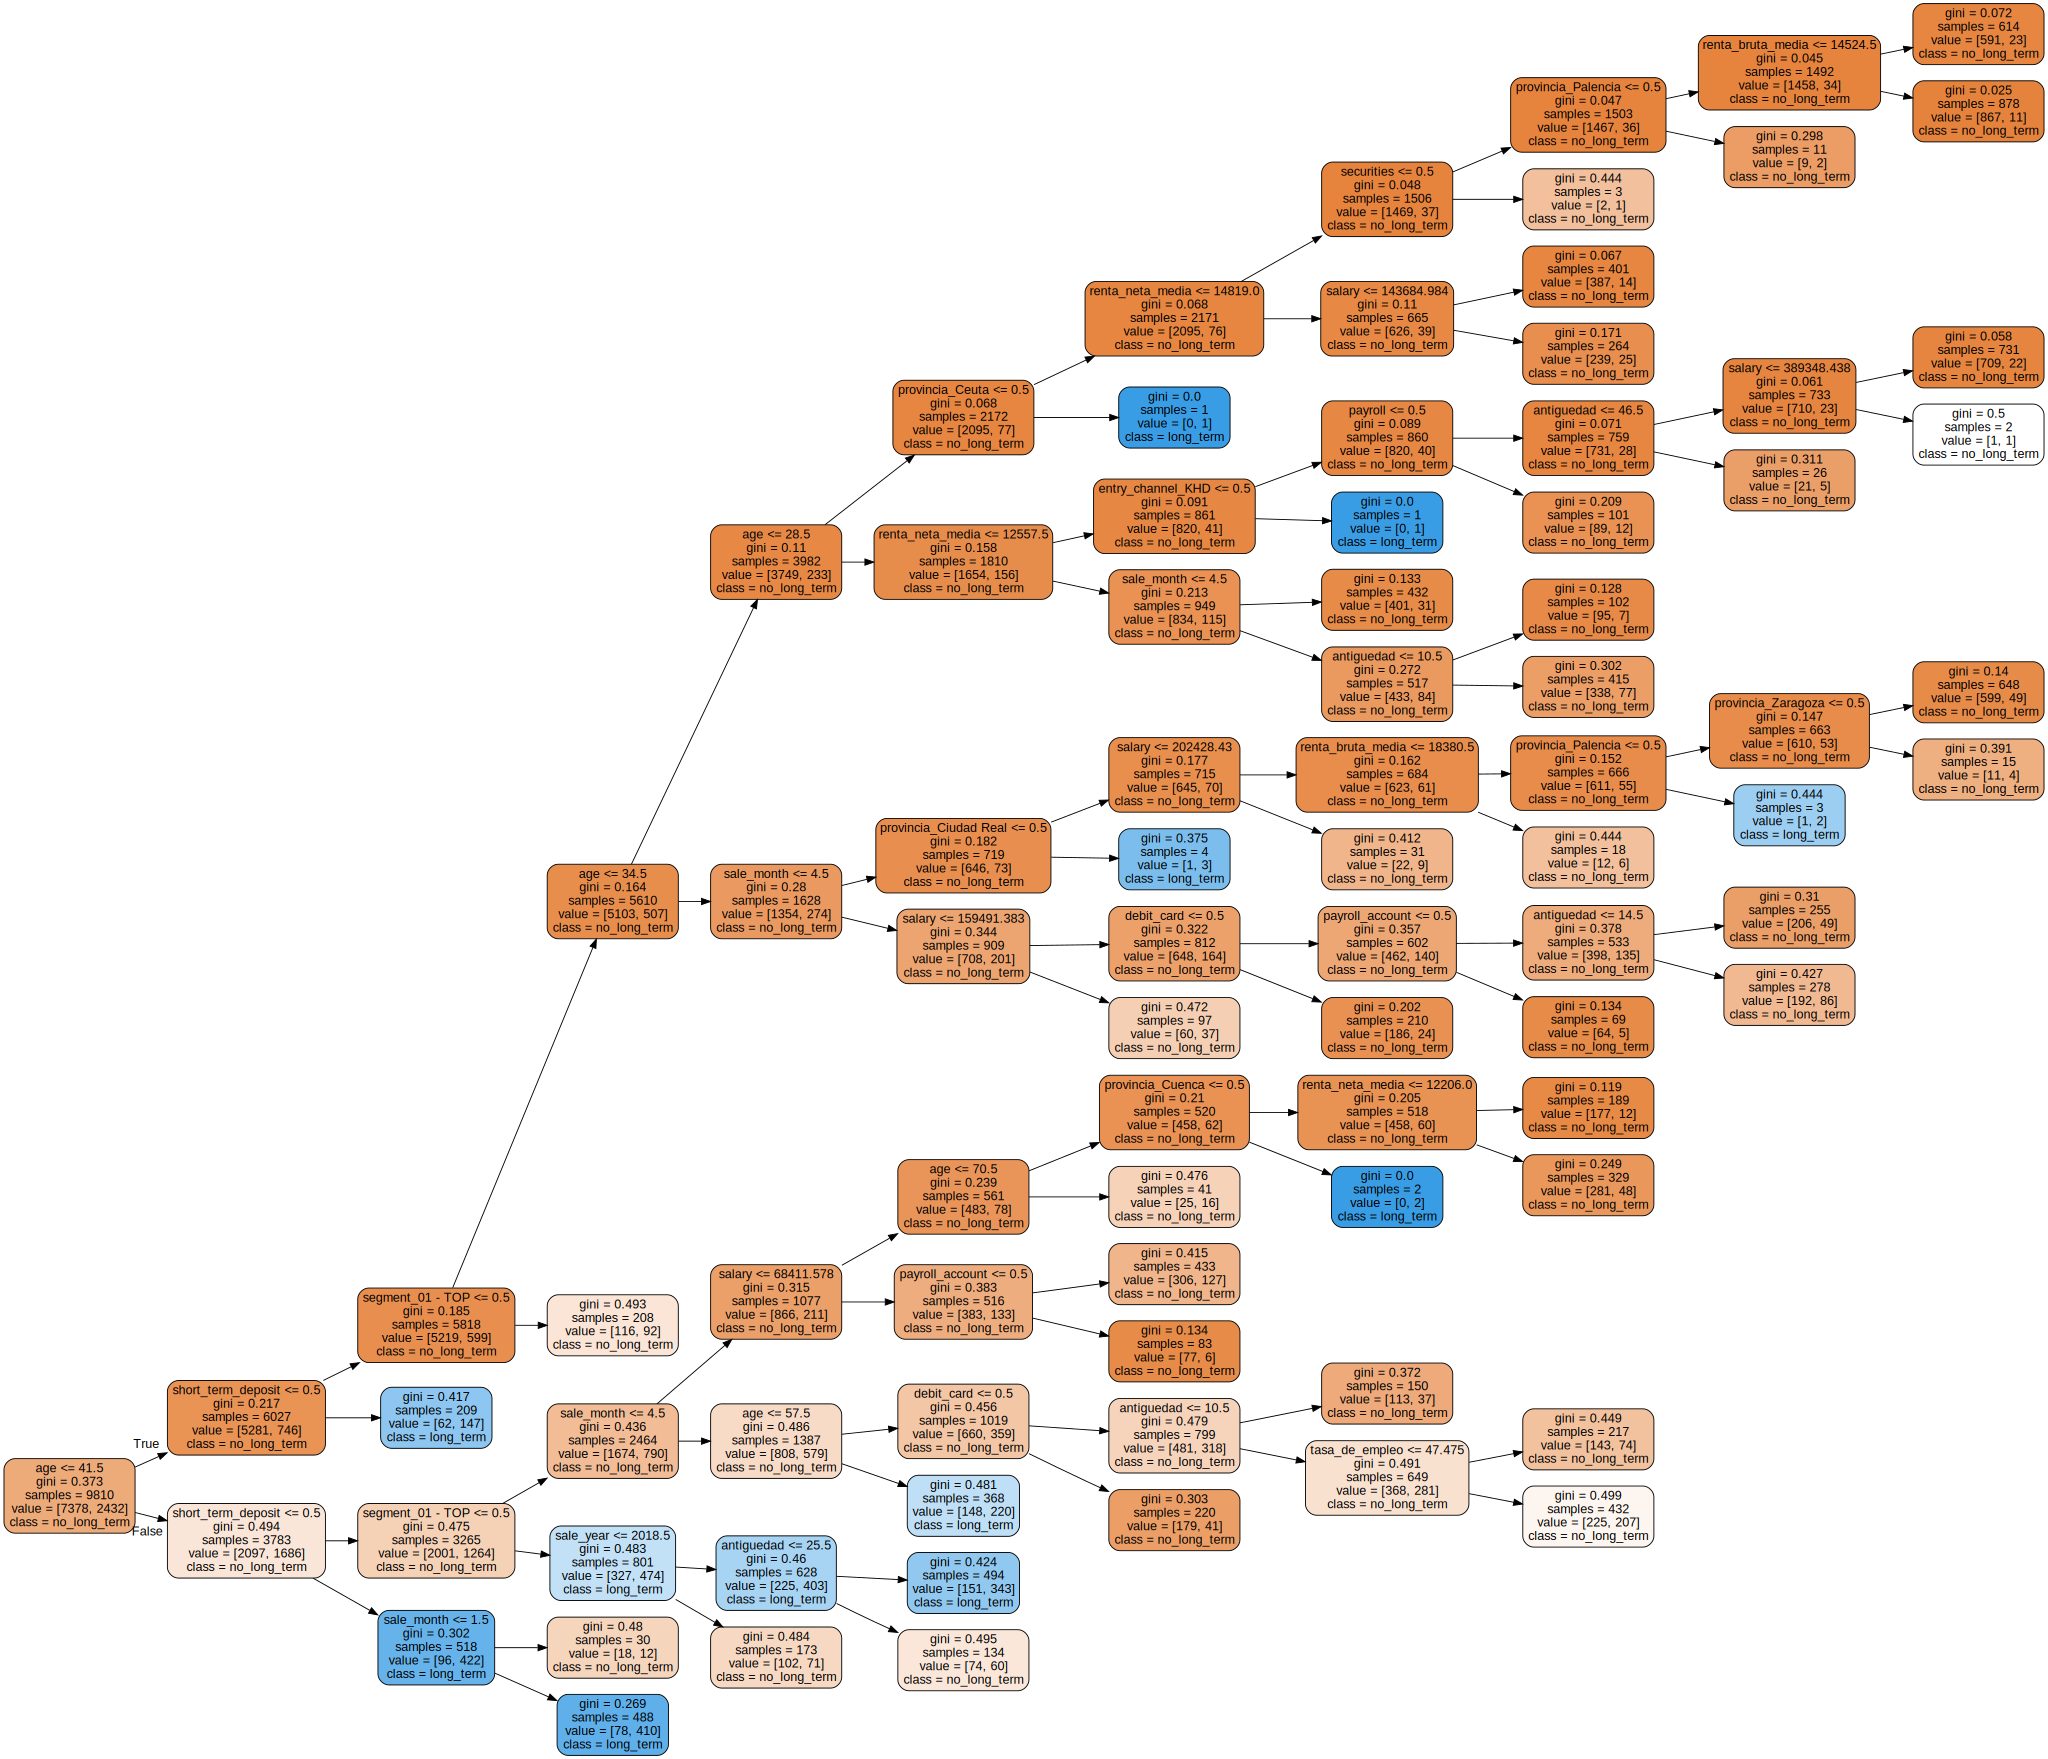

In [231]:
graphviz.Source(tree_data)

In [232]:
#generamos predicciones y evaluamos el modelo
y_test_pred = pd.DataFrame(dt.predict(X_test),index=y_test.index,columns=['long_term_prediction'])

In [233]:
#join de y_test y y_test_pred para comparar el resultado real con la predicción
result_df=y_test.join(y_test_pred,how='inner')

In [234]:
result_df['Success']=(result_df['product_ID_2336']==result_df['long_term_prediction']).astype(int)

In [235]:
result_df.head()

,product_ID_2336,long_term_prediction,Success
customer_ID,,,
56347,1,0,0
64859,0,1,0
70102,1,1,1
76927,0,0,1
77195,1,0,0


In [236]:
dt_acc_train=dt.score(X_train, y_train)
dt_acc_train

0.8222222222222222

In [237]:
dt.score(X_test, y_test)

0.8159021406727829

In [238]:
dt_acc_val=dt.score(val_df_X,val_df_y)
dt_acc_val
#En validación el resultado es decente, acierta un 68% de una distribución de 50 que tiene nuestro TARGET

0.9449992318328468

Métricas calidad

In [239]:
def metricas(y_test = y_test, y_test_pred = y_test_pred):
  modelo_tonto = dev_df_y[TARGET].mean()
  acc = metrics.accuracy_score(y_test,y_test_pred)
  precision = metrics.precision_score(y_test,y_test_pred)
  recall = metrics.recall_score(y_test,y_test_pred)
  f1_score = metrics.f1_score(y_test,y_test_pred)

  print(f"Accuracy: {acc}. > El modelo tonto daría: {modelo_tonto}" )
  print(f"Precision: {precision}. > Cuántos positivos de los que detecta realmente lo son")
  print(f"Recall: {recall}. > Cuántos positivos detecta el modelo del total")
  print(f"F1_Score: {f1_score}")

In [240]:
metricas()

Accuracy: 0.8159021406727829. > El modelo tonto daría: 0.25
Precision: 0.7226415094339622. > Cuántos positivos de los que detecta realmente lo son
Recall: 0.45704057279236276. > Cuántos positivos detecta el modelo del total
F1_Score: 0.5599415204678362


## AUC y ROC curve

In [241]:
y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=['long_term_score']).sort_values(by='long_term_score', ascending=False)

In [242]:
result_df = result_df.join(y_score)

In [243]:
result_df.sort_values(by='long_term_score', ascending=False).head()

,product_ID_2336,long_term_prediction,Success,long_term_score
customer_ID,,,,
1398700,1,1,1,0.840164
1303805,1,1,1,0.840164
1396383,1,1,1,0.840164
1377663,1,1,1,0.840164
1396328,1,1,1,0.840164


In [244]:
metrics.roc_auc_score(result_df['product_ID_2336'],result_df['long_term_score'])

0.8307061371095021

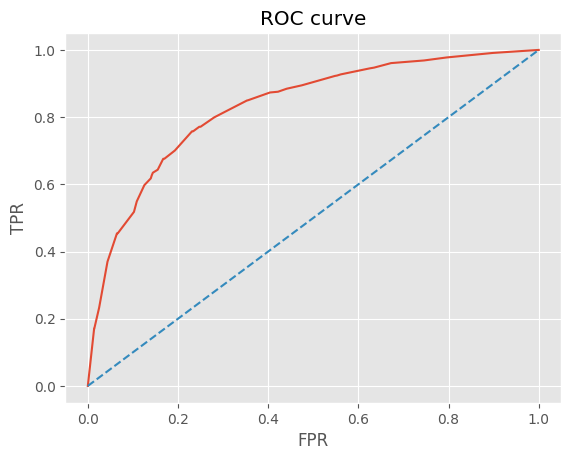

In [245]:
fpr_2,tpr_2,th_2=metrics.roc_curve(result_df['product_ID_2336'],result_df['long_term_score'])
plt.plot(fpr_2,tpr_2)
plt.plot([0,1],[0,1],linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

## Control del overfitting Decission Tree

In [246]:
for i in range(1,15):
  #instancio el modelo
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42)
  #entreno el modelo
  dt2.fit(X_train,y_train)
  #evaluo
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)
  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.75209,Acc.test: 0.743731
Profundidad de arbol: 2, Acc.train: 0.793986,Acc.test: 0.790214
Profundidad de arbol: 3, Acc.train: 0.809582,Acc.test: 0.808869
Profundidad de arbol: 4, Acc.train: 0.813252,Acc.test: 0.814679
Profundidad de arbol: 5, Acc.train: 0.823649,Acc.test: 0.814679
Profundidad de arbol: 6, Acc.train: 0.83211,Acc.test: 0.819878
Profundidad de arbol: 7, Acc.train: 0.837309,Acc.test: 0.817737
Profundidad de arbol: 8, Acc.train: 0.842712,Acc.test: 0.815291
Profundidad de arbol: 9, Acc.train: 0.855963,Acc.test: 0.81682
Profundidad de arbol: 10, Acc.train: 0.867788,Acc.test: 0.812538
Profundidad de arbol: 11, Acc.train: 0.88053,Acc.test: 0.797554
Profundidad de arbol: 12, Acc.train: 0.893068,Acc.test: 0.801529
Profundidad de arbol: 13, Acc.train: 0.907849,Acc.test: 0.789908
Profundidad de arbol: 14, Acc.train: 0.919878,Acc.test: 0.791131


In [247]:
#puedo probar con diferent numero de observaciones en el nodo final
for i in range(1,15):
  dt2= DecisionTreeClassifier(max_depth=i,random_state=42,min_samples_split=500)
  dt2.fit(X_train,y_train)
  acc_train = dt2.score(X_train,y_train)
  acc_test = dt2.score(X_test,y_test)


  print(f'Profundidad de arbol: {i}, Acc.train: {np.round(acc_train,6)},Acc.test: {np.round(acc_test,6)}')

Profundidad de arbol: 1, Acc.train: 0.75209,Acc.test: 0.743731
Profundidad de arbol: 2, Acc.train: 0.793986,Acc.test: 0.790214
Profundidad de arbol: 3, Acc.train: 0.809582,Acc.test: 0.808869
Profundidad de arbol: 4, Acc.train: 0.812742,Acc.test: 0.814373
Profundidad de arbol: 5, Acc.train: 0.821509,Acc.test: 0.816208
Profundidad de arbol: 6, Acc.train: 0.821814,Acc.test: 0.815902
Profundidad de arbol: 7, Acc.train: 0.82212,Acc.test: 0.815902
Profundidad de arbol: 8, Acc.train: 0.82212,Acc.test: 0.815902
Profundidad de arbol: 9, Acc.train: 0.822222,Acc.test: 0.815902
Profundidad de arbol: 10, Acc.train: 0.822222,Acc.test: 0.815902
Profundidad de arbol: 11, Acc.train: 0.822324,Acc.test: 0.815902
Profundidad de arbol: 12, Acc.train: 0.822324,Acc.test: 0.815902
Profundidad de arbol: 13, Acc.train: 0.822324,Acc.test: 0.815902
Profundidad de arbol: 14, Acc.train: 0.822324,Acc.test: 0.815902


## Modelos alternativos

### RANDOM FOREST

In [248]:
#Random Forest con 10 replicas
rf_2 = RandomForestClassifier(max_depth=10,random_state=42,min_samples_split=500,n_estimators=10)

In [249]:
rf_2.fit(X_train,y_train)

<ipython-input-249-7bdf2188c4c9>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_2.fit(X_train,y_train)


RandomForestClassifier(max_depth=10, min_samples_split=500, n_estimators=10,
                       random_state=42)

In [250]:
rf_acc_train=rf_2.score(X_train,y_train)
rf_acc_train

0.7968399592252803

In [251]:
rf_2.score(X_test,y_test)

0.7948012232415902

In [252]:
rf_acc_val=rf_2.score(val_df_X,val_df_y)
rf_acc_val
# ¿?¿? El resultado es malísimo en validación

0.9798740205868797

### XGBOOST (sklearn)

In [253]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

In [254]:
gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)

In [255]:
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [256]:
acc_grad=gb.score(X_train,y_train)
acc_grad

0.8382262996941896

In [257]:
gb.score(X_test,y_test)

0.8195718654434251

In [258]:
acc_grad_val=gb.score(val_df_X,val_df_y)
acc_grad_val
#En validación el resultado mejora, acierta un 78% de una distribución de 50 que tiene nuestro TARGET

0.9953909970809648

### Establecimiento de hiperparámetros óptimos para el GradientBoosting

In [259]:
param_grid = {
    'n_estimators': [20, 50, 70, 100],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

In [260]:
model_gb = GradientBoostingClassifier()

In [261]:
grid_search = GridSearchCV(estimator=model_gb, param_grid=param_grid, cv=5)
grid_search.fit(X_train, np.ravel(y_train))

KeyboardInterrupt: ignored

In [ ]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [ ]:
print(best_params)
print(best_model)

In [ ]:
accuracy = best_model.score(X_test, y_test)
print(accuracy)

## XGBOOST (original)

In [262]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)

In [263]:
params = {
    'max_depth': 6,
    'eta': 0.3,
    'objective': 'binary:logistic',
    'eval_metric': 'logloss'
}

# Entrenar el modelo
num_rounds = 100
model_xgb = xgb.train(params, dtrain, num_rounds)

In [264]:
dtest = xgb.DMatrix(data=X_test)

In [265]:
predictions = model_xgb.predict(dtest)

In [266]:
predictions

array([0.7234385 , 0.09421634, 0.18950781, ..., 0.03316986, 0.20130835,
       0.03156035], dtype=float32)

In [267]:
from sklearn.metrics import accuracy_score

In [268]:
# Convertir las predicciones a etiquetas binarias (0 o 1)
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]

In [269]:
# Calcular el accuracy
accuracy_xgboost = accuracy_score(y_test, binary_predictions)
print("Accuracy:", accuracy_xgboost)

Accuracy: 0.8143730886850153


In [270]:
dval = xgb.DMatrix(data=val_df_X, label=val_df_y)

In [271]:
val_predictions = model_xgb.predict(dval)

In [272]:
binary_val_predictions = [1 if p >= 0.5 else 0 for p in val_predictions]

In [273]:
val_accuracy_xgboost = accuracy_score(val_df_y, binary_val_predictions)
print("Validation Accuracy:", val_accuracy_xgboost)

Validation Accuracy: 0.9907819941619297


## Variables más predictivas

In [274]:
top_features_dt = pd.Series(dt.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [275]:
top_features_dt
# Aquí vemos las variables que el modelo Decision Tree ha considerado como más predictivas

age                      0.457377
short_term_deposit       0.255577
segment_01 - TOP         0.114650
sale_month               0.071003
antiguedad               0.023554
debit_card               0.016389
salary                   0.014543
sale_year                0.012010
payroll_account          0.008935
renta_neta_media         0.006278
tasa_de_empleo           0.004562
provincia_Ciudad Real    0.002799
provincia_Cuenca         0.002577
renta_bruta_media        0.002195
provincia_Palencia       0.002158
provincia_Ceuta          0.001540
entry_channel_KHD        0.001503
payroll                  0.000990
provincia_Zaragoza       0.000886
securities               0.000474
dtype: float64

In [276]:
top_features_2_rd = pd.Series(rf_2.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [277]:
top_features_2_rd
# Aquí vemos las variables que el modelo Random Forest ha considerado como más predictivas

age                           0.279244
segment_01 - TOP              0.122563
short_term_deposit            0.116888
antiguedad                    0.078912
segment_03 - UNIVERSITARIO    0.064483
sale_month                    0.056290
segment_02 - PARTICULARES     0.051018
debit_card                    0.043156
sale_year                     0.019407
renta_neta_media              0.018808
payroll_account               0.016369
salary                        0.014818
entry_channel_KHK             0.012905
entry_channel_KHE             0.011602
entry_channel_KFA             0.011481
tasa_de_paro                  0.009876
tasa_de_empleo                0.008764
provincia_Madrid              0.008758
entry_channel_KHL             0.008114
payroll                       0.007154
dtype: float64

In [278]:
top_features_2_gb = pd.Series(gb.feature_importances_, index=X_train.columns).sort_values(ascending=False).head(20)

In [279]:
top_features_2_gb
# Aquí vemos las variables que el modelo Gradient Boosting ha considerado como más predictivas

age                   0.418824
short_term_deposit    0.215422
segment_01 - TOP      0.100789
sale_month            0.073876
antiguedad            0.030569
debit_card            0.027602
salary                0.022469
sale_year             0.019550
payroll_account       0.018898
tasa_de_paro          0.015649
payroll               0.010586
entry_channel_KHE     0.005806
renta_neta_media      0.004949
tasa_de_empleo        0.004457
entry_channel_RED     0.002660
entry_channel_KFA     0.002650
provincia_Palencia    0.002274
funds                 0.002098
credit_card           0.001997
entry_channel_KFC     0.001978
dtype: float64

## Comparación entre modelos

In [280]:
RANDOM_STATE = 42
n_estimators = 50
max_depth = 8

models = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE))
]

ROC AUC Score for DecisionTree: 0.8044544301909308
ROC AUC Score for RandomForest: 0.8495971081679439
ROC AUC Score for GradientBoosting: 0.8554915663076247


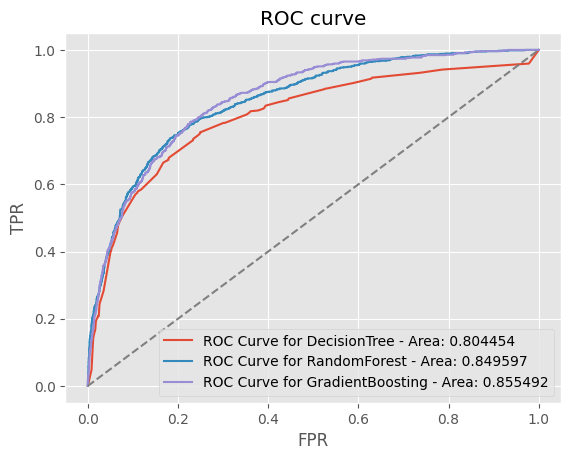

In [281]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

In [282]:
print(f"Decision Tree Train: {dt_acc_train}")
print(f"Decision Tree Val: {dt_acc_val}")
print()
print(f"Random forest Train: {rf_acc_train}")
print(f"Random forest Val: {rf_acc_val}")
print()
print(f"Gradient Boosting Train: {acc_grad}")
print(f"Gradient Boosting Val: {acc_grad_val}")
print()
print(f"XGBoost Train:{accuracy_xgboost}")
print(f"XGBoost Val: {val_accuracy_xgboost}")
print()

Decision Tree Train: 0.8222222222222222
Decision Tree Val: 0.9449992318328468

Random forest Train: 0.7968399592252803
Random forest Val: 0.9798740205868797

Gradient Boosting Train: 0.8382262996941896
Gradient Boosting Val: 0.9953909970809648

XGBoost Train:0.8143730886850153
XGBoost Val: 0.9907819941619297



#Ajustes en el dataset de predicción

In [283]:
#aplicamos las misma transformaciones que hemos aplicado al dataset de development y validación

In [315]:
df_total_pred.head()



,customer_ID,partition_ID,entry_channel,segment,antiguedad,country_id,gender,age,salary,provincia,...,securities,credit_card,payroll,pension_plan,payroll_account,emc_account,debit_card,em_acount,month_sale,product_ID
2261834,657826,2019-05-01,OTHERS,02 - PARTICULARES,49.0,ES,H,44.0,54493.38,Lleida,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261835,657986,2019-05-01,OTHERS,02 - PARTICULARES,40.0,ES,H,39.0,100993.17,Sevilla,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaT,NaN
2261836,657905,2019-05-01,KAT,01 - TOP,27.0,ES,H,85.0,154059.09,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261837,657336,2019-05-01,KAT,02 - PARTICULARES,2.0,ES,V,38.0,0.00,Madrid,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,NaT,NaN
2261838,658184,2019-05-01,KAT,02 - PARTICULARES,49.0,ES,V,42.0,183036.72,Madrid,...,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,NaT,NaN


In [348]:
df_total_pred_1=df_total_pred.copy()

In [349]:
df_total_pred_1.drop("partition_ID", axis = 1, inplace = True)

In [350]:
df_total_pred_1.columns

Index(['customer_ID', 'entry_channel', 'segment', 'antiguedad', 'country_id',
       'gender', 'age', 'salary', 'provincia', 'renta_neta_media',
       'renta_bruta_media', 'tasa_de_paro', 'tasa_de_empleo',
       'short_term_deposit', 'loans', 'mortgage', 'funds', 'securities',
       'credit_card', 'payroll', 'pension_plan', 'payroll_account',
       'emc_account', 'debit_card', 'em_acount', 'month_sale', 'product_ID'],
      dtype='object')

In [351]:
df_total_pred_1= df_total_pred_1.reindex(columns=[
              'month_sale',
              'product_ID',
              'customer_ID',
              'antiguedad',
              'entry_channel',
              'segment',
              'country_id',
              'gender',
              'age',
              'salary',
              'provincia',
              'renta_neta_media',
              'renta_bruta_media',
              'tasa_de_paro',
              'tasa_de_empleo',
              'short_term_deposit',
              'loans',
              'mortgage',
              'funds',
              'securities',
              'credit_card',
              'payroll',
              'payroll_account',
              'pension_plan',
              'debit_card',
              'em_acount',
              ])

In [352]:
# Disgregamos la variable de "month_sale" y eliminamos la variable de fecha
df_total_pred_1['sale_month'] = df_total_pred_1['month_sale'].dt.month
df_total_pred_1['sale_year'] = df_total_pred_1['month_sale'].dt.year


del df_total_pred_1['month_sale']

In [353]:
df_total_pred_1.head().T

,2261834,2261835,2261836,2261837,2261838
product_ID,NaN,NaN,NaN,NaN,NaN
customer_ID,657826,657986,657905,657336,658184
antiguedad,49.0,40.0,27.0,2.0,49.0
entry_channel,OTHERS,OTHERS,KAT,KAT,KAT
segment,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES
country_id,ES,ES,ES,ES,ES
gender,H,H,H,V,V
age,44.0,39.0,85.0,38.0,42.0
salary,54493.38,100993.17,154059.09,0.0,183036.72
provincia,Lleida,Sevilla,Madrid,Madrid,Madrid


In [354]:
#elimnamos la columna target
del df_total_pred_1['product_ID']


In [355]:
df_total_pred_1.head().T

,2261834,2261835,2261836,2261837,2261838
customer_ID,657826,657986,657905,657336,658184
antiguedad,49.0,40.0,27.0,2.0,49.0
entry_channel,OTHERS,OTHERS,KAT,KAT,KAT
segment,02 - PARTICULARES,02 - PARTICULARES,01 - TOP,02 - PARTICULARES,02 - PARTICULARES
country_id,ES,ES,ES,ES,ES
gender,H,H,H,V,V
age,44.0,39.0,85.0,38.0,42.0
salary,54493.38,100993.17,154059.09,0.0,183036.72
provincia,Lleida,Sevilla,Madrid,Madrid,Madrid
renta_neta_media,12896.0,10717.0,15579.0,15579.0,15579.0


In [356]:
df_total_pred_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171514 entries, 2261834 to 2433347
Data columns (total 26 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   customer_ID         171514 non-null  int64   
 1   antiguedad          171514 non-null  float64 
 2   entry_channel       171514 non-null  category
 3   segment             171514 non-null  object  
 4   country_id          171514 non-null  category
 5   gender              171514 non-null  object  
 6   age                 171514 non-null  float64 
 7   salary              171514 non-null  float64 
 8   provincia           171514 non-null  object  
 9   renta_neta_media    171514 non-null  float64 
 10  renta_bruta_media   171514 non-null  float64 
 11  tasa_de_paro        171514 non-null  float64 
 12  tasa_de_empleo      171514 non-null  float64 
 13  short_term_deposit  171514 non-null  float64 
 14  loans               171514 non-null  float64 
 15  mortgage  

In [294]:
#tranformación de categóricas

In [357]:
def OHE(dataframe, column_name):
    _dummy_dataset = pd.get_dummies(dataframe[column_name], prefix=column_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    return dataframe.drop(column_name, axis=1)

In [358]:
# OHE "entry_channel"

df_total_pred_1 = OHE(df_total_pred_1, "entry_channel")

In [359]:
# OHE segment

df_total_pred_1 = OHE(df_total_pred_1, "segment")

In [360]:
# OHE country_id
df_total_pred_1 = OHE(df_total_pred_1, "country_id")

In [361]:
# OHE provincia
df_total_pred_1 = OHE(df_total_pred_1, "provincia")

In [362]:
# gender --> 1 = Hembras, 0 = Varones, 2 = Nulos

df_total_pred_1["gender"] = df_total_pred_1["gender"].replace("H", 1) # H es de Hembras
df_total_pred_1["gender"] = df_total_pred_1["gender"].replace("V", 0) # V es de Varones

In [363]:
df_total_pred_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171514 entries, 2261834 to 2433347
Data columns (total 95 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   customer_ID                       171514 non-null  int64  
 1   antiguedad                        171514 non-null  float64
 2   gender                            171514 non-null  int64  
 3   age                               171514 non-null  float64
 4   salary                            171514 non-null  float64
 5   renta_neta_media                  171514 non-null  float64
 6   renta_bruta_media                 171514 non-null  float64
 7   tasa_de_paro                      171514 non-null  float64
 8   tasa_de_empleo                    171514 non-null  float64
 9   short_term_deposit                171514 non-null  float64
 10  loans                             171514 non-null  float64
 11  mortgage                          171514 non-

In [302]:
#rellammos  sale month y  sale year con la fecha de venta que queremos predecir, 2019-06

In [364]:
df_total_pred_1['sale_month'].fillna(value = 6, inplace = True)
df_total_pred_1['sale_year'].fillna(value = 2019, inplace = True)

In [365]:
df_total_pred_1.head().T

,2261834,2261835,2261836,2261837,2261838
customer_ID,657826.00,657986.00,657905.00,657336.00,658184.00
antiguedad,49.00,40.00,27.00,2.00,49.00
gender,1.00,1.00,1.00,0.00,0.00
age,44.00,39.00,85.00,38.00,42.00
salary,54493.38,100993.17,154059.09,0.00,183036.72
renta_neta_media,12896.00,10717.00,15579.00,15579.00,15579.00
renta_bruta_media,11767.00,14550.00,15183.00,15183.00,15183.00
tasa_de_paro,9.77,23.75,13.25,13.25,13.25
tasa_de_empleo,54.89,43.28,53.60,53.60,53.60
short_term_deposit,0.00,0.00,0.00,0.00,0.00


In [366]:
df_total_pred_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171514 entries, 2261834 to 2433347
Data columns (total 95 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   customer_ID                       171514 non-null  int64  
 1   antiguedad                        171514 non-null  float64
 2   gender                            171514 non-null  int64  
 3   age                               171514 non-null  float64
 4   salary                            171514 non-null  float64
 5   renta_neta_media                  171514 non-null  float64
 6   renta_bruta_media                 171514 non-null  float64
 7   tasa_de_paro                      171514 non-null  float64
 8   tasa_de_empleo                    171514 non-null  float64
 9   short_term_deposit                171514 non-null  float64
 10  loans                             171514 non-null  float64
 11  mortgage                          171514 non-

In [367]:
df_total_pred_1['sale_month']=df_total_pred_1['sale_month'].astype('int')
df_total_pred_1['sale_year']=df_total_pred_1['sale_year'].astype('int')

In [369]:
del df_total_pred_1['provincia_No definido']
del df_total_pred_1['segment_04 - NO SEGMENT']
del df_total_pred_1['pension_plan']
del df_total_pred_1['country_id_OTHERS']
#del df_total_pred_1['renta_neta_media']
#del df_total_pred_1['tasa_de_paro']



In [370]:
df_total_pred_1=df_total_pred_1.set_index("customer_ID")

In [371]:
df_final_pred_long_term_deposit=df_total_pred_1.to_pickle('/content/drive/MyDrive/TFM  Data Science/df_final_pred_long_term_deposit') # Eva
#df_final_pred_long_term_deposit=df_total_pred_1.to_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_final_pred_long_term_deposit') # Ricard
#df_final_pred_long_term_deposit=df_total_pred_1.to_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_final_pred_long_term_deposit') # Culebra

In [372]:
df_final_pred_long_term_deposit=pd.read_pickle('/content/drive/MyDrive/TFM  Data Science/df_final_pred_long_term_deposit')# Eva
#df_final_pred_long_term_deposit=pd.read_pickle('/content/drive/MyDrive/NUCLIO/TFM  Data Science/df_final_pred_long_term_deposit') # Ricard
#df_final_pred_long_term_deposit=pd.read_pickle('/content/drive/MyDrive/Master_DS/TFM_Data_Science/df_final_pred_long_term_deposit') # Culebra

#Predicciones

In [ ]:
#predecimos con el decission tree que es que mejor resultados ha dado en validación

In [373]:
pred_long_term_deposit=dt.predict(df_final_pred_long_term_deposit)

In [375]:
pred_long_term_deposit

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [376]:
print(pred_long_term_deposit)

[0 0 0 ... 0 0 0]


In [ ]:
#predecimos con el xgboost

In [377]:
datos_pred=xgb.DMatrix(df_final_pred_long_term_deposit)

In [379]:
pred_xgboost_long_term_deposit=model_xgb.predict(datos_pred)

In [380]:
print(pred_xgboost_long_term_deposit)

[0.14390174 0.02774399 0.18491936 ... 0.0020222  0.02402089 0.01023524]
